# Importing Modules

In [4]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import xgboost as xgb
import random
import pickle
import requests

from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from scipy                 import stats as ss
from matplotlib.gridspec   import GridSpec
from sklearn.preprocessing import RobustScaler,MinMaxScaler,LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from sklearn.linear_model  import LinearRegression,Lasso
from sklearn.ensemble      import RandomForestRegressor
from IPython.core.display  import HTML
from IPython.display       import Image

# Functions

In [5]:
sns.set_style('darkgrid')
def ml_error(model_name,y,yhat):
    mae=mean_absolute_error(y,yhat)
    mape=mean_absolute_percentage_error(y,yhat)
    rmse=np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({'Model Name':model_name,'MAE':mae,'MAPE':mape,'RMSE':rmse},index=[0])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).to_numpy()
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def cross_validation(x_training,kfold,model_name,model):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        #print('\nKFold Number:{}'.format(k))
        #Start and End date for validation
        validation_start_date = x_training['date'].max()-datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max()-datetime.timedelta(days=(k-1)*6*7)

        #Filterind dataset
        training = x_training[x_training['date']<validation_start_date]
        validation = x_training[(x_training['date']>=validation_start_date) & (x_training['date']<=validation_end_date)]

        #Training and Validation dataset
        xtraining = training.drop(['date','sales'],axis=1)
        ytraining = training['sales']
        xvalidation = validation.drop(['date','sales'],axis=1)
        yvalidation = validation['sales']

        #Model
        m = model.fit(xtraining,ytraining)

        #Prediction
        yhat = m.predict(xvalidation)

        #Performance
        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))

        #Returning Results
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name':model_name,'MAE Cross Validation': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),'MAPE Cross Validation': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),'RMSE Cross Validation': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])

# Loading Data

In [6]:
df_sales_raw = pd.read_csv('data_raw/train.csv',low_memory=False)
df_store_raw = pd.read_csv('data_raw/store.csv',low_memory=False)

# Merge
df = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# Data Description

## Rename Columns

In [7]:
df.columns
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,cols_old))
df.columns = cols_new


## Treating NA Values

In [8]:
df['date'] = pd.to_datetime(df['date'])
df.isna().sum()

## Filling NA

df['competition_distance'].max()
df['competition_distance'] = df['competition_distance'].fillna(200000)

df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df['competition_open_since_year'] = df['competition_open_since_year'].fillna(df['date'].dt.year)
             
df['promo2_since_week'] = df['promo2_since_week'].fillna(df['date'].dt.isocalendar().week)

df['promo2_since_year'] = df['promo2_since_year'].fillna(df['date'].dt.year)
                 
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
df['promo_interval'].fillna(0, inplace=True)
df['month_map'] = df['date'].dt.month.map(month_map)
df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## Change Types

In [9]:
df.dtypes
df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
df['promo2_since_week'] = df['promo2_since_week'].astype(int)
df['promo2_since_year'] = df['promo2_since_year'].astype(int)

## Descriptive Statistics

<AxesSubplot:xlabel='sales', ylabel='Count'>

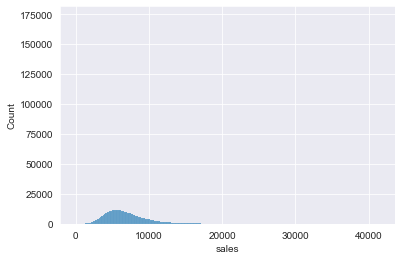

In [10]:
num_attributes = df.select_dtypes(include=['int64','float64'])
cat_attributes = df.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

d1 = num_attributes.describe().T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()))
d2.columns = ['skew']
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()))
d3.columns = ['kurtosis']
num_attributes_describe = pd.concat([d1,d2,d3],axis=1).reset_index()

sns.histplot(df['sales'])

In [11]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

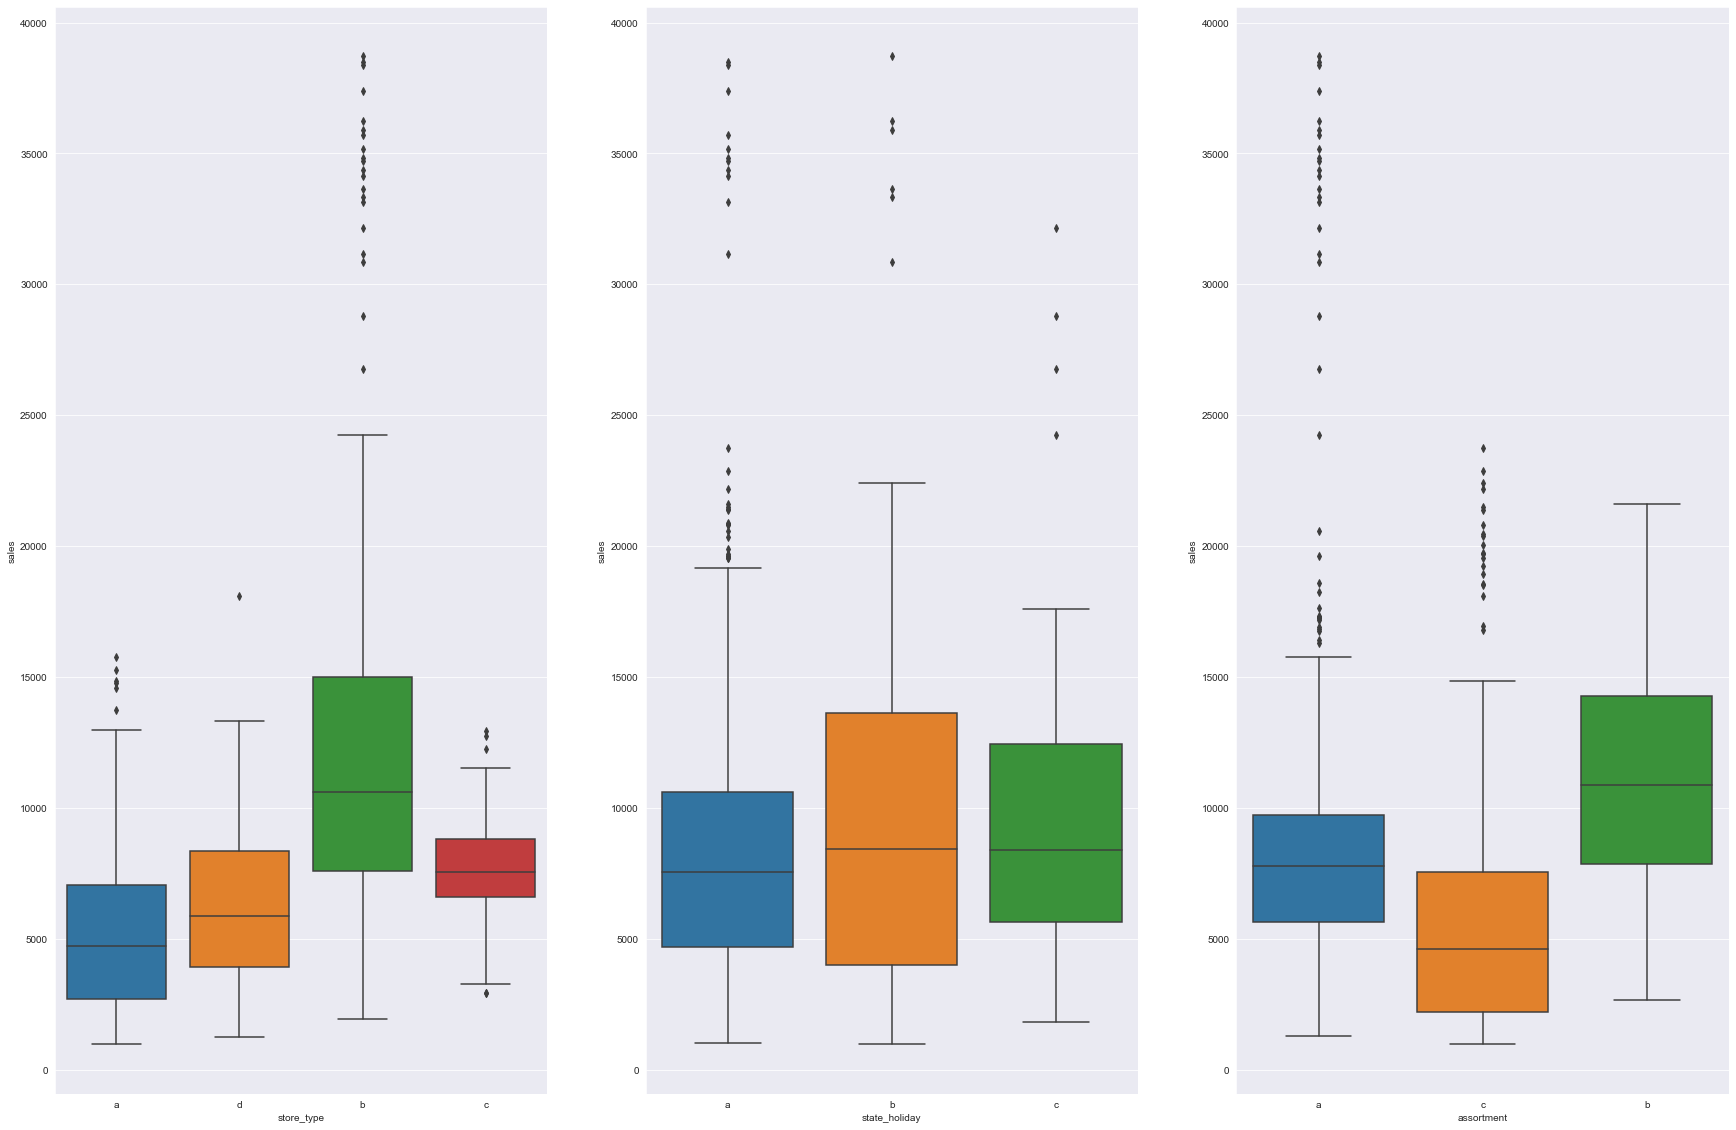

In [12]:
plt.rcParams['figure.figsize'] = [30, 20]
aux = df[(df['state_holiday'] != '0') & (df['sales'] > 0)]
plt.subplot(1,3,1)
sns.boxplot(x='store_type',y='sales',data=aux)            
plt.subplot(1,3,2)
sns.boxplot(x='state_holiday',y='sales',data=aux) 
plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux)

# Feature Engineering

## Hypothesis List

**1.** Store with more assortment should have higher sales.

**2.** Store closer to the competitor should have lower sales 

**3.** Store with competitors for longer should have higher sales

**4.** Stores with longer activated promotions should have higher sales. 
    
**5.** Stores with more days in promotion should have higher sales.
    
**6.** Stores with more consecutives promotions should have higher sales.

**7.** Stores open during Christmas period should have higher sales.

**8.** Stores should increase their sales year by year

**9.** Stores should have higher sales on the second half of the year

**10.** Stores should have higher sales after the 10th of each month 

**11.** Stores should have lower sales on weekends

**12.** Stores should have lower sales on school holidays

In [13]:
df2=df.copy()

## Feature Engineering

In [14]:
# year
df2['year']=df2['date'].dt.year
# month
df2['month']=df2['date'].dt.month
# day
df2['day']=df2['date'].dt.day
# week of year
df2['week_of_year']=df2['date'].dt.week
# year week
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


<ipython-input-14-2d02db7cae96>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year']=df2['date'].dt.week


In [15]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# Variables Filtering

In [16]:
df3 = df2.copy()

In [17]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis=1)

# Exploratory Data Analysis

In [18]:
df4 = df3.copy()

## Response Variable

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales'>

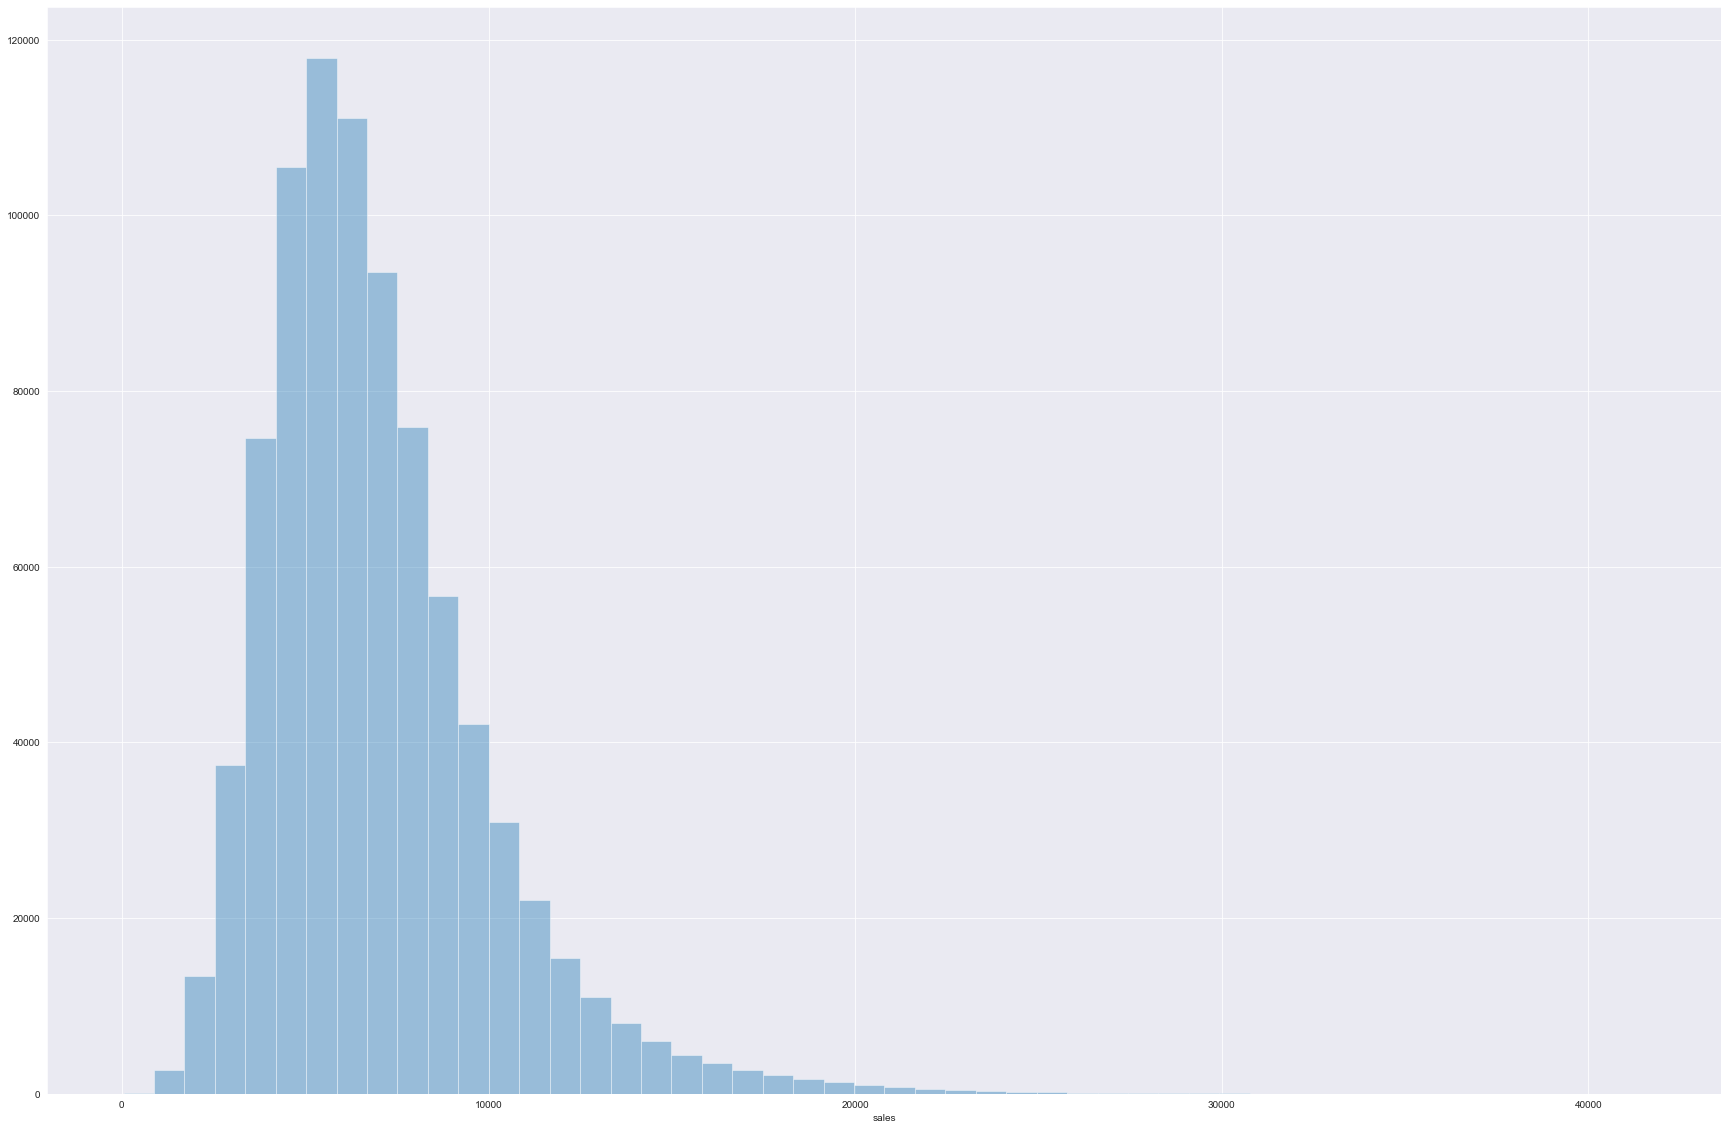

In [19]:
sns.distplot(df4['sales'],kde=False)

## Numerical Variable

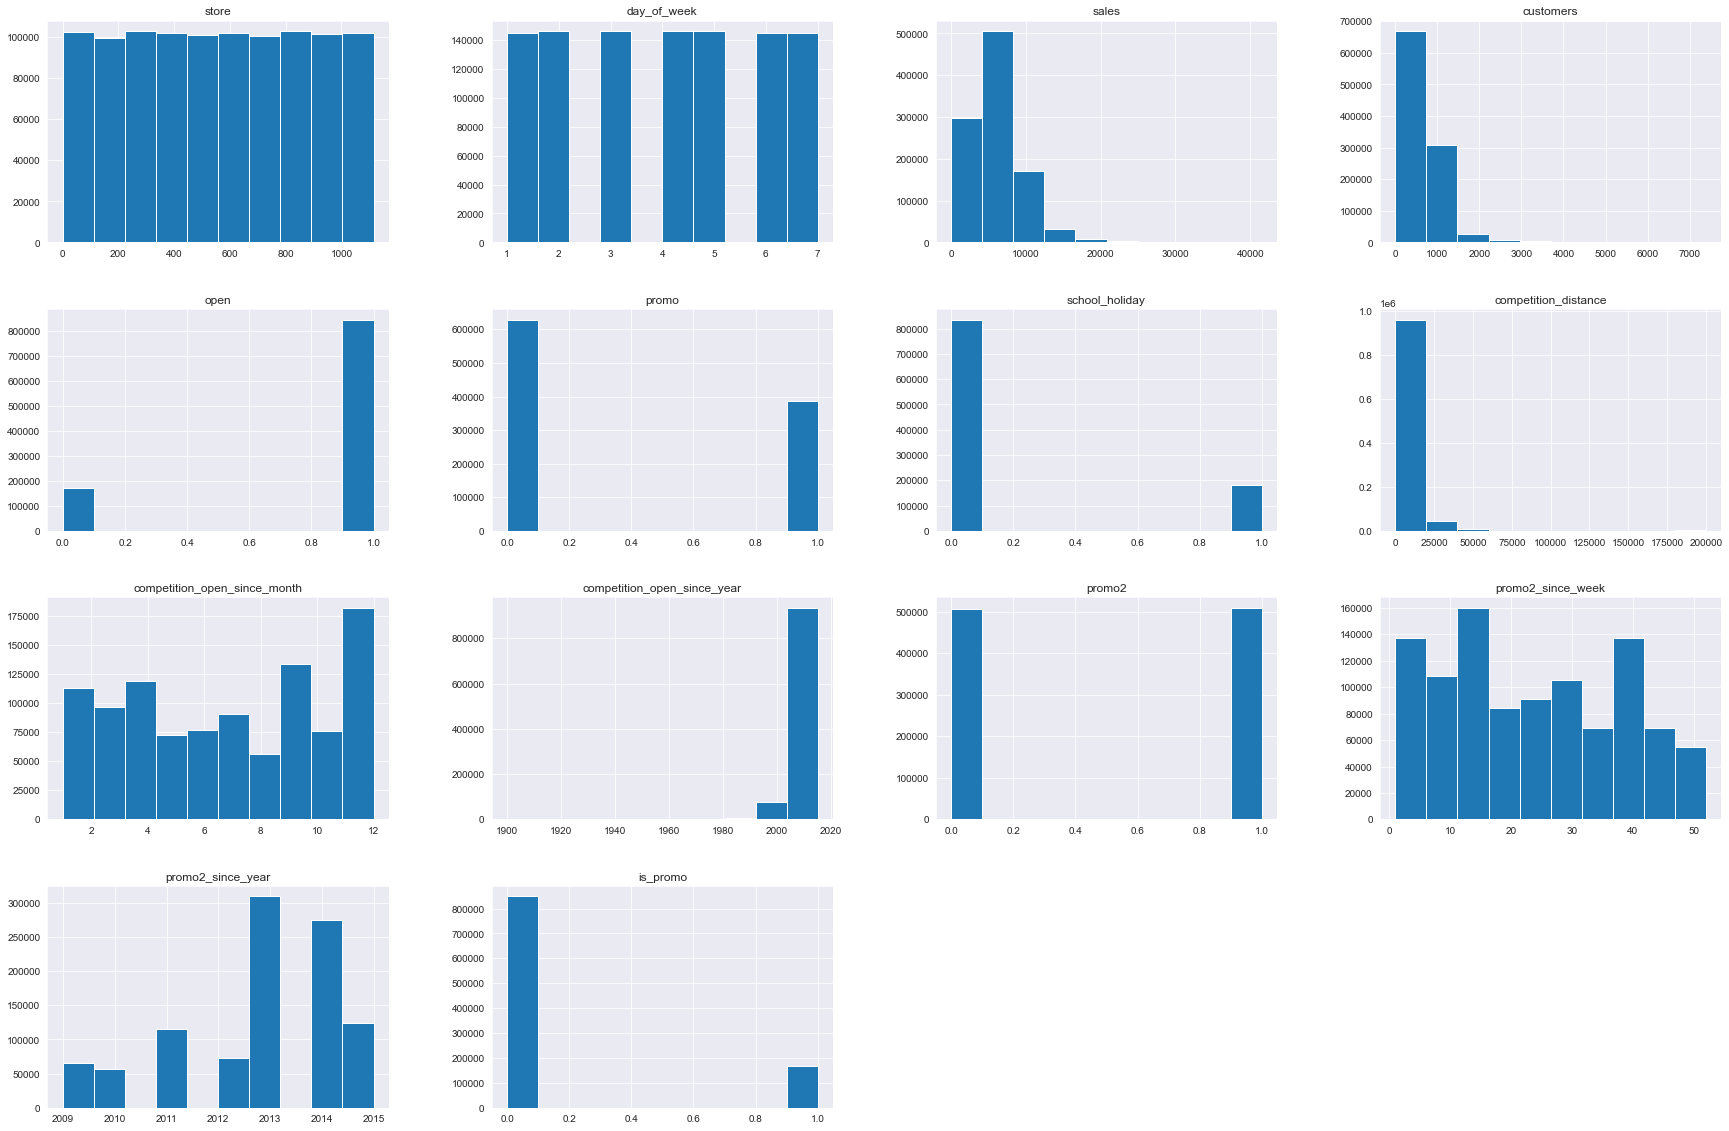

In [20]:
num_attributes.hist();

## Categorical Variable

In [21]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

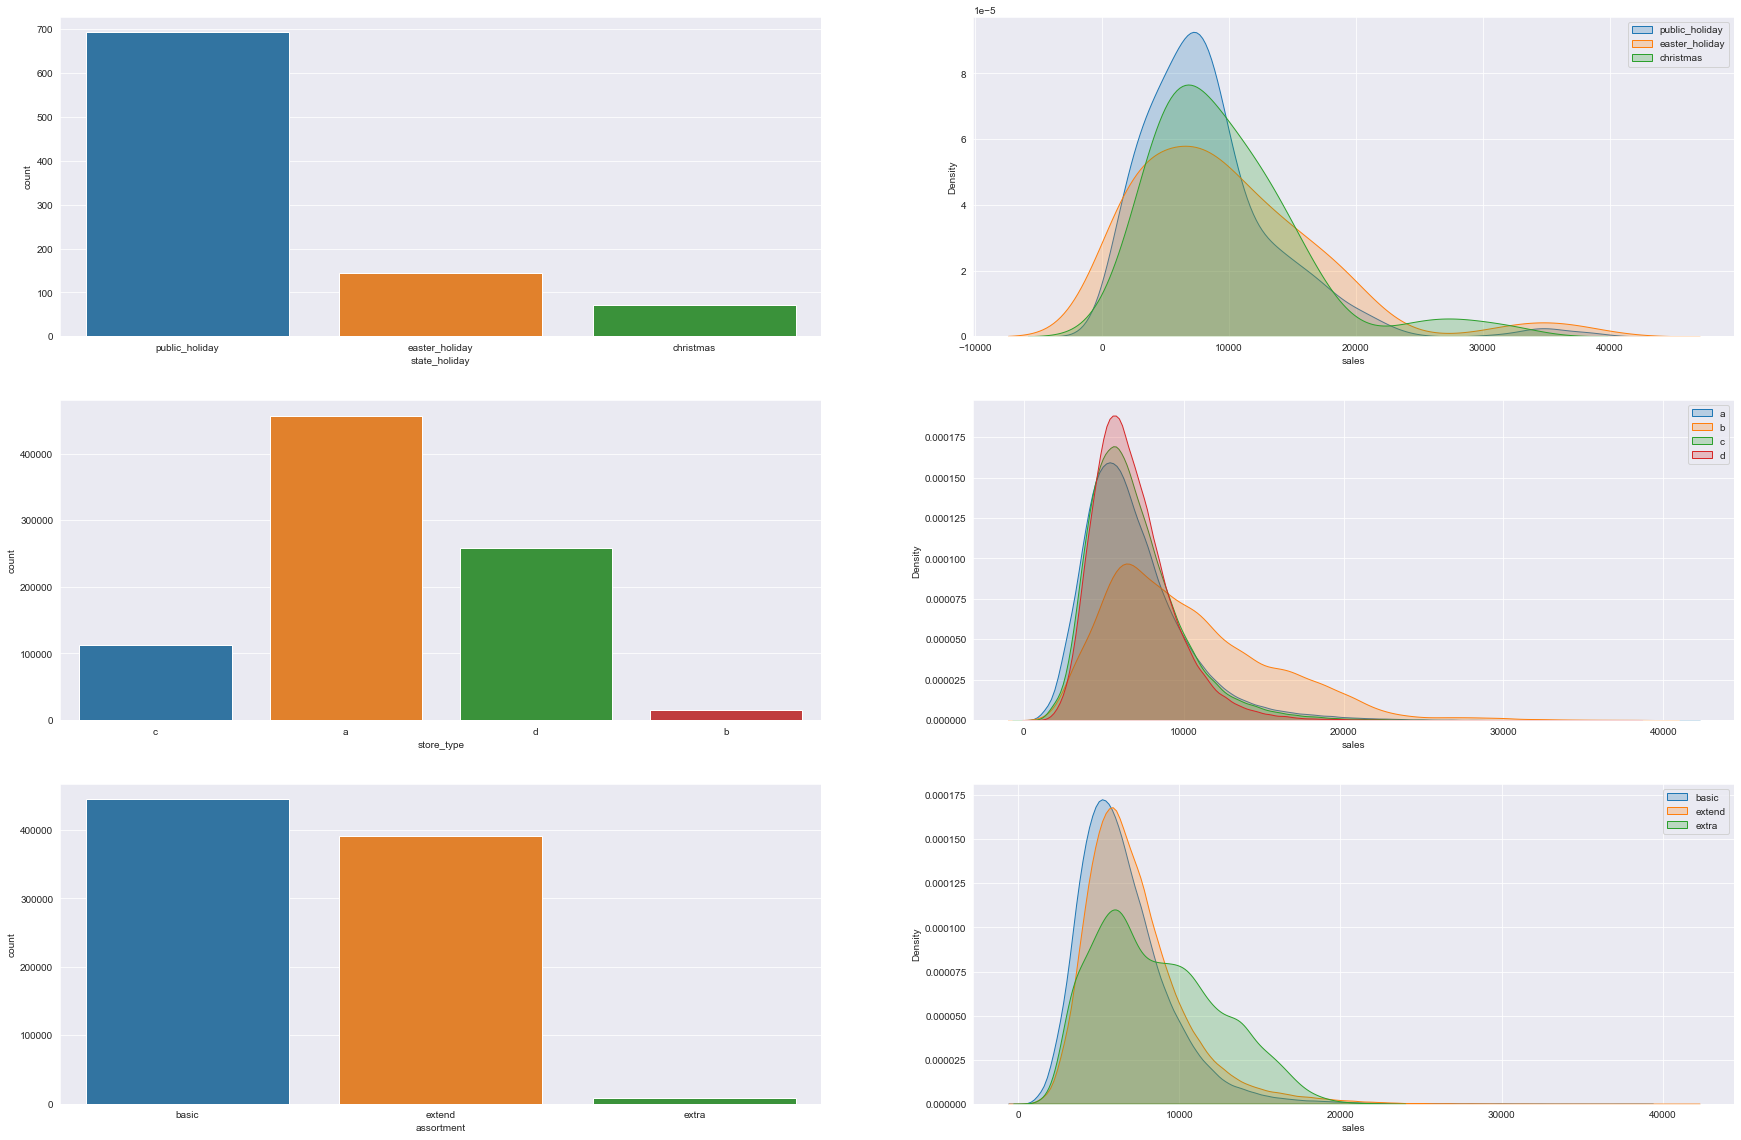

In [22]:
# State Holiday
a = df4[df4['state_holiday'] != 'regular_day']
plt.subplot(3,2,1)
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas',shade=True)
plt.legend()

# Store Type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d',shade=True)
plt.legend()

# Assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extend']['sales'], label='extend',shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra',shade=True)
plt.legend()



## Bivariate Analysis

### H1 - Store with more assortment should have higher sales.
***FALSE***

<AxesSubplot:xlabel='year_week'>

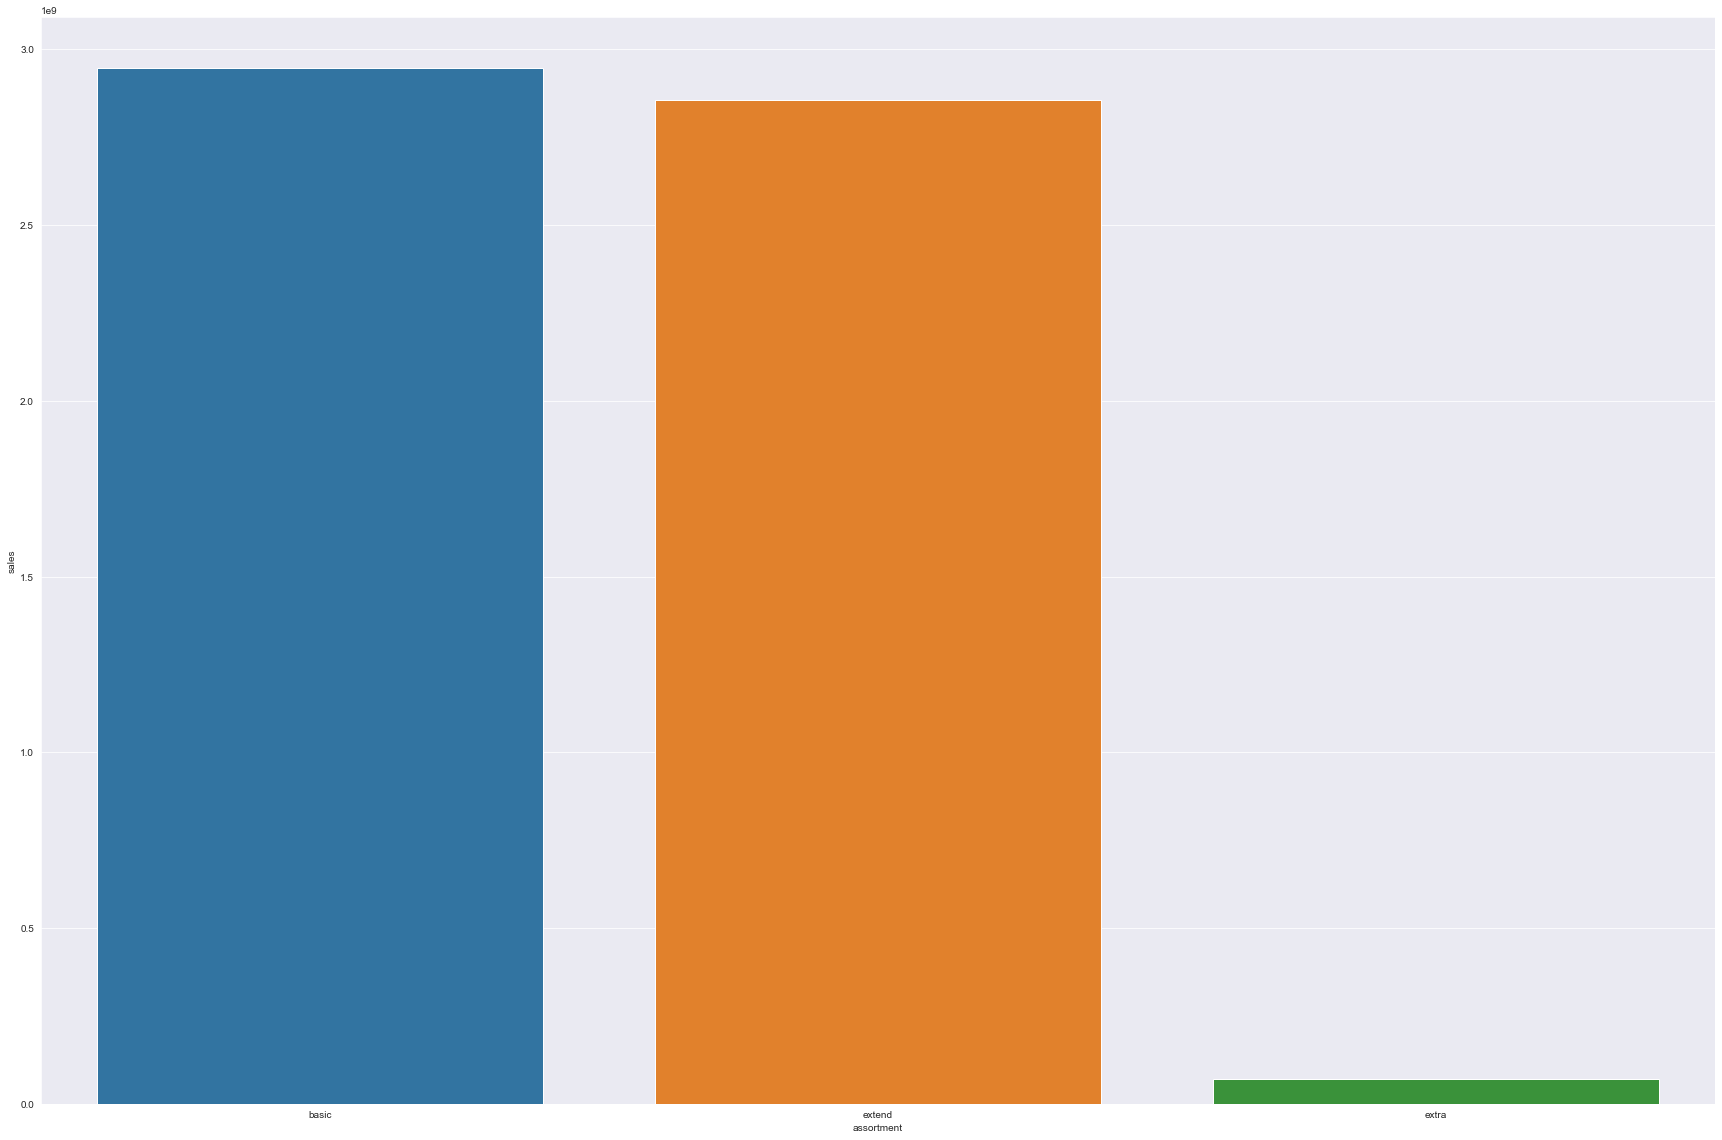

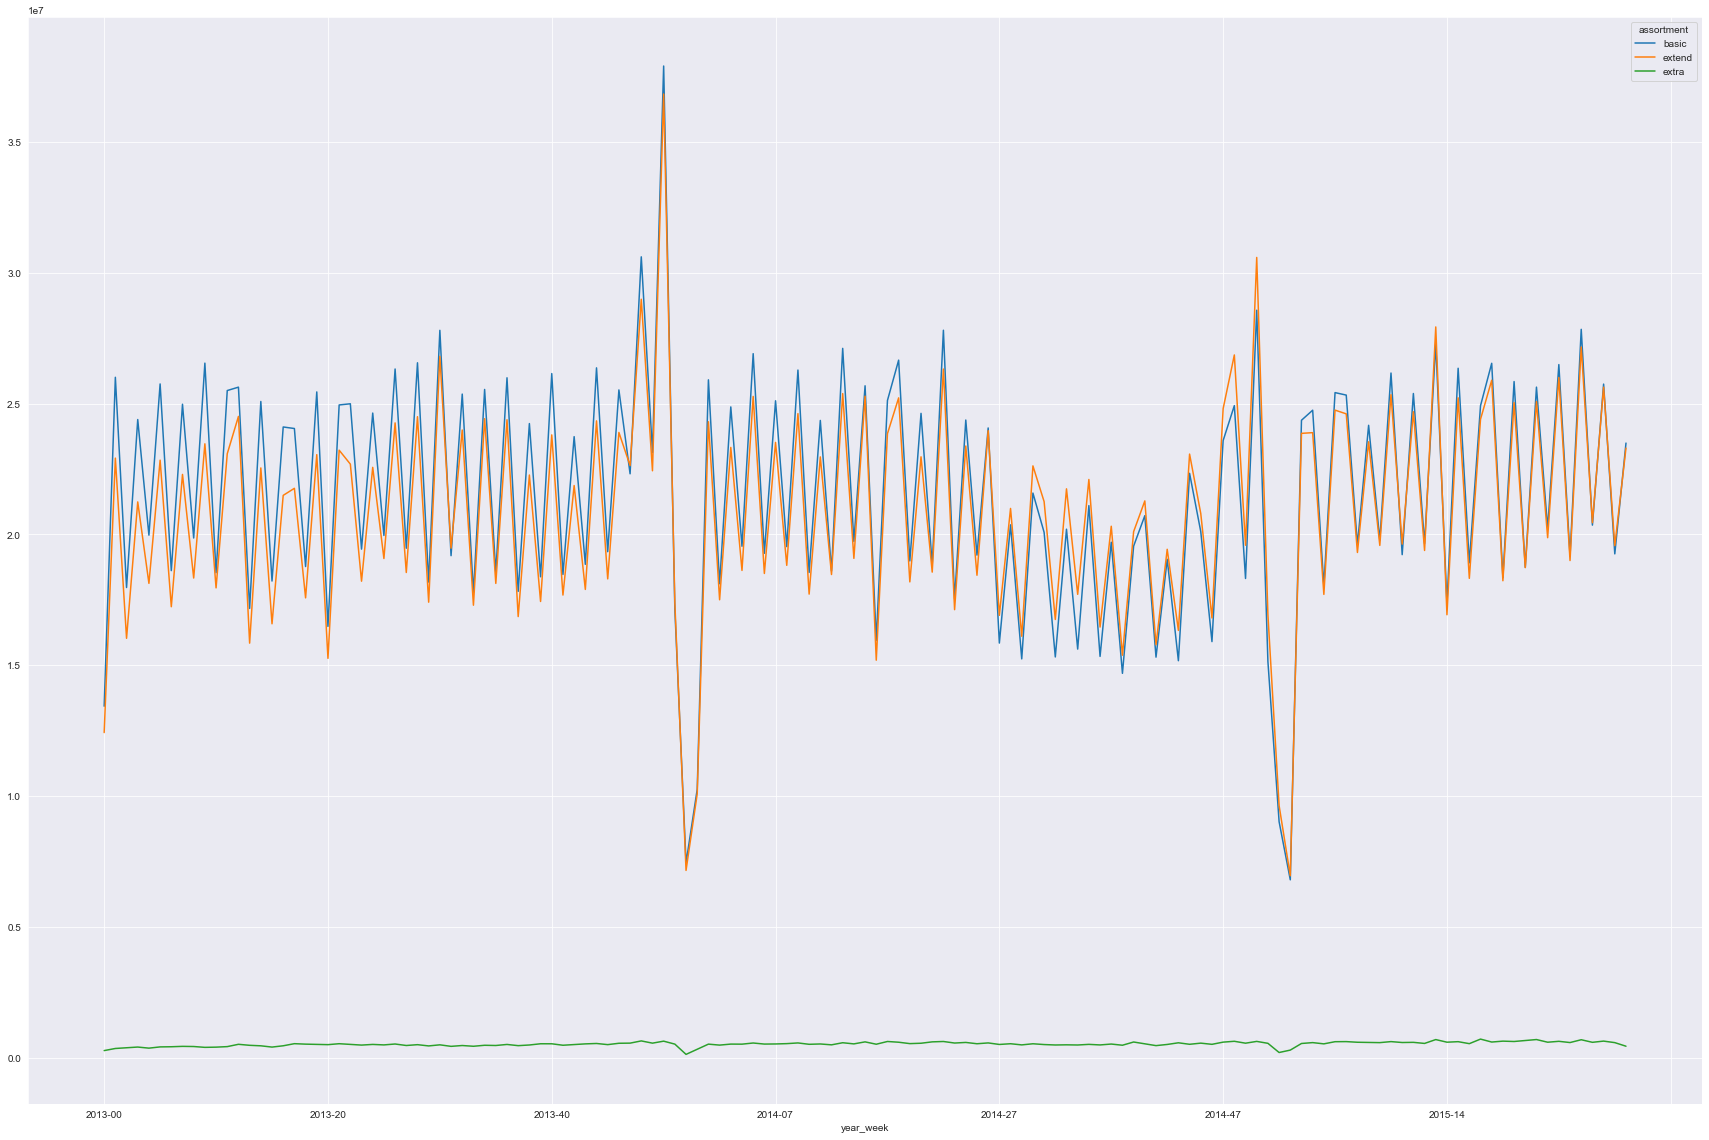

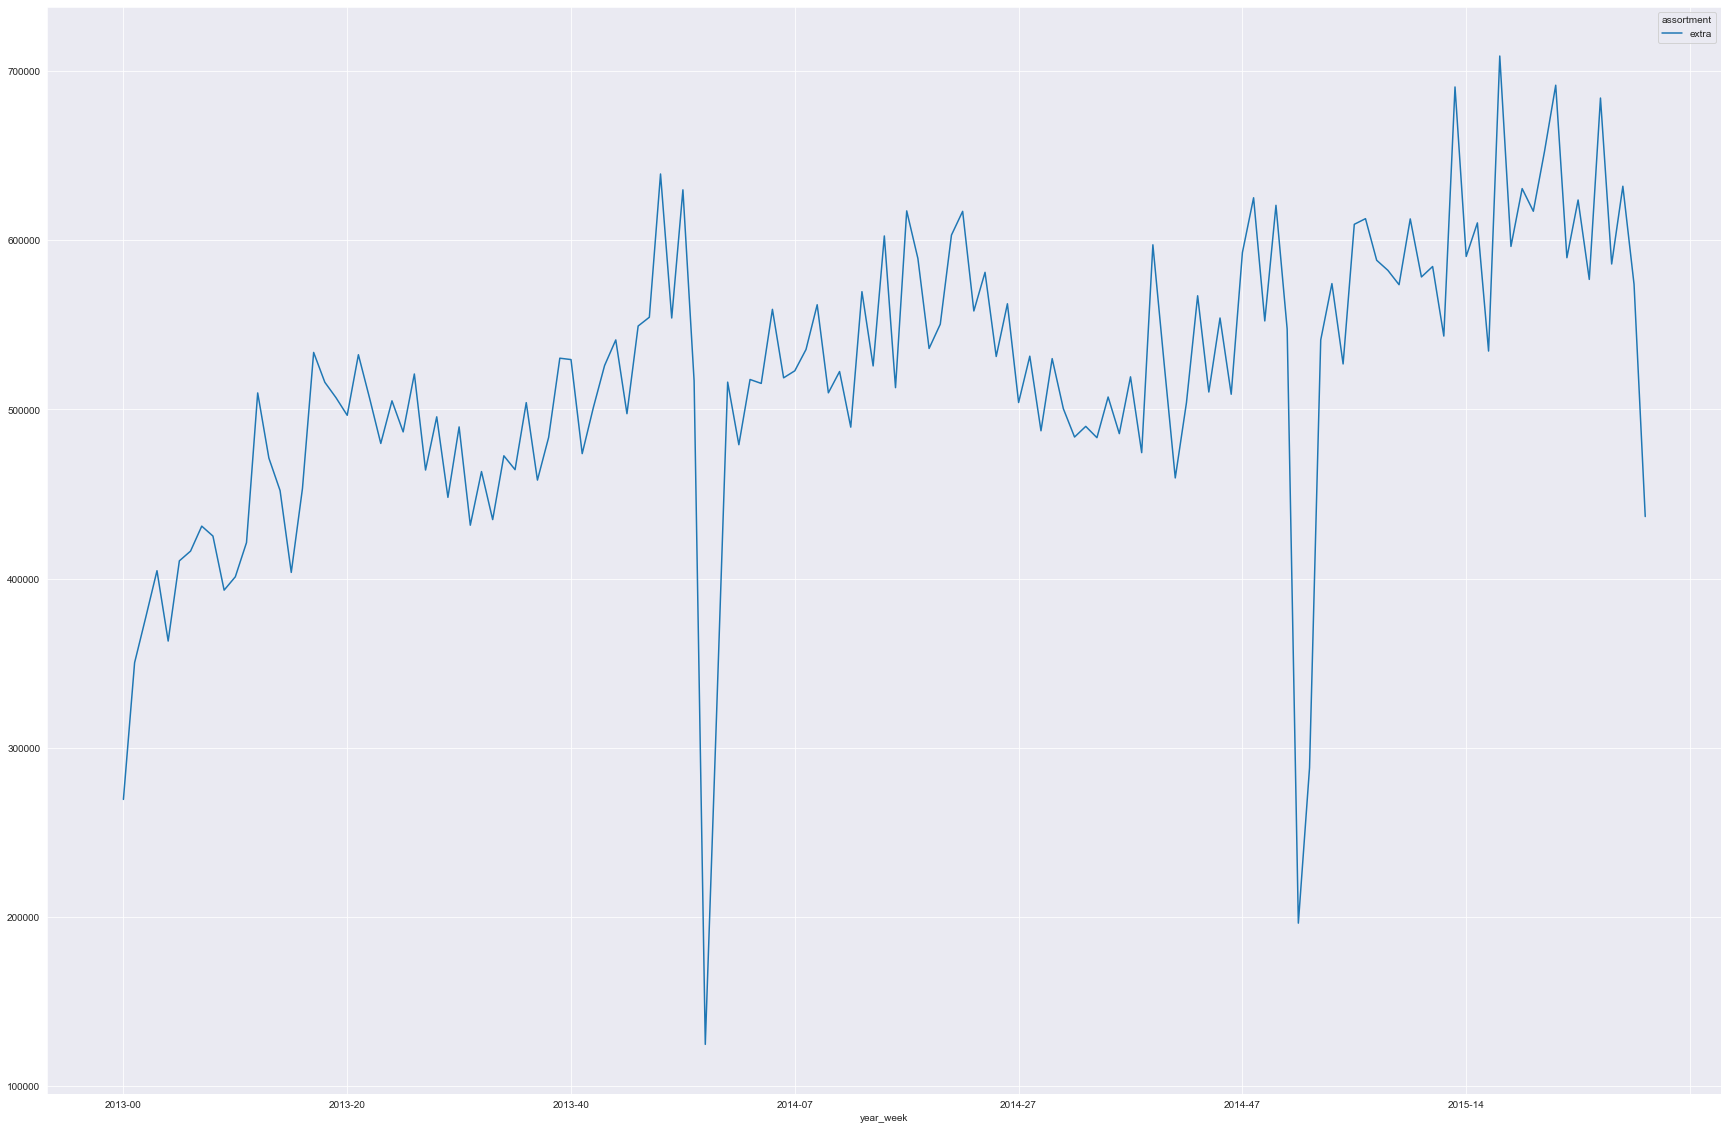

In [23]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week',columns='assortment',values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week',columns='assortment',values='sales').plot()

### H2 - Store closer to the competitor should have lower sales 
***FALSE***

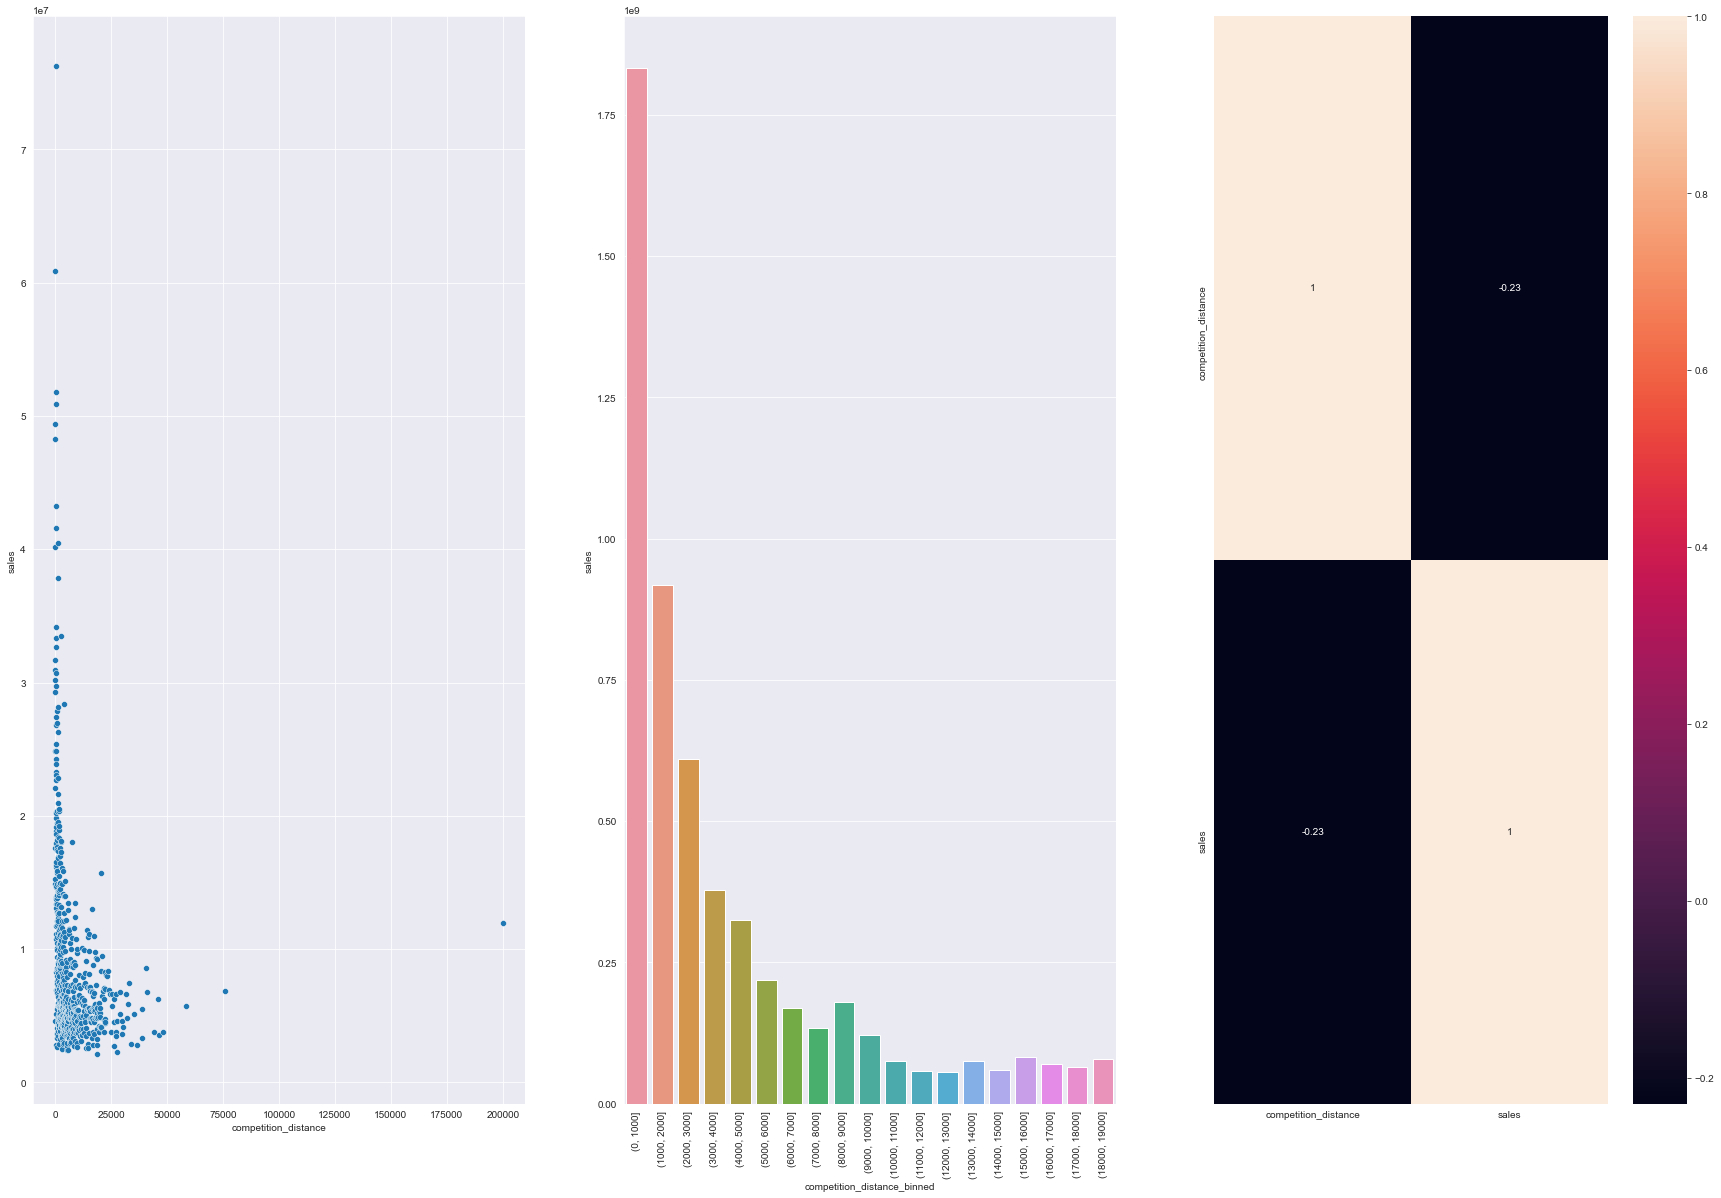

In [24]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'],bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned',y='sales',data=aux2);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H3 - Store with competitors for longer should have higher sales
***FALSE***

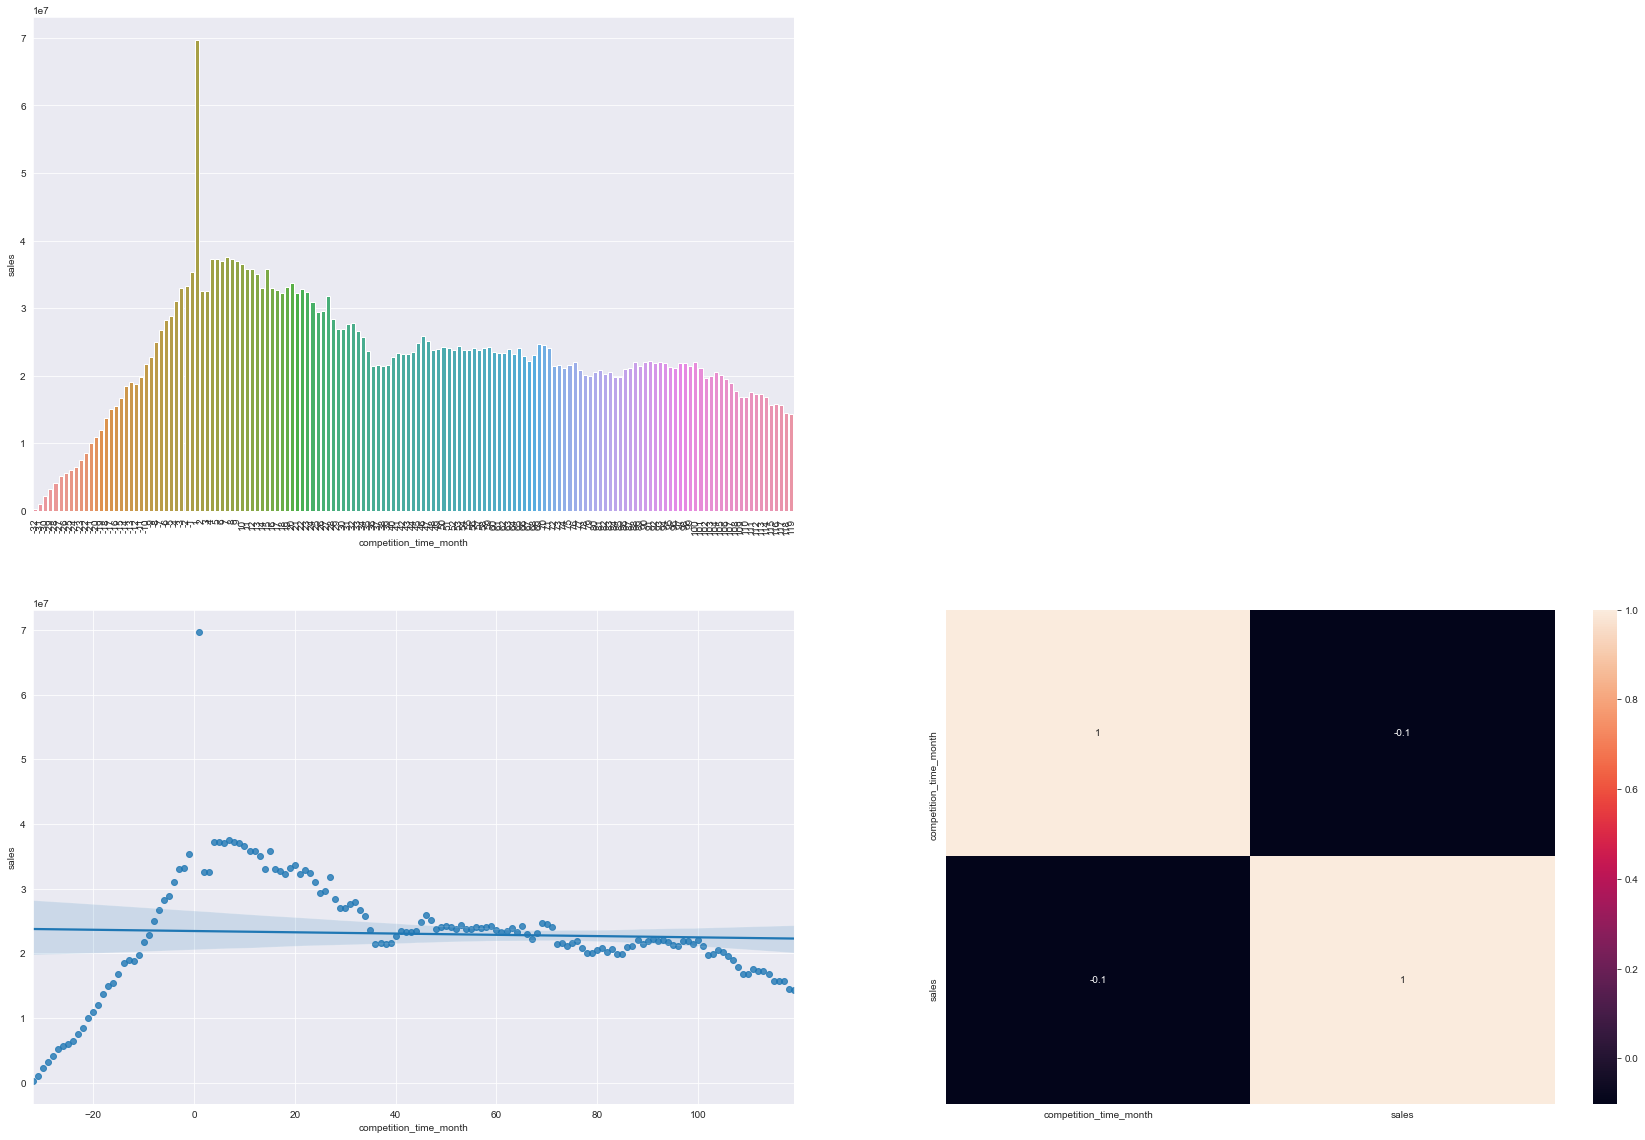

In [25]:
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120)  & (aux1['competition_time_month'] != 0)]

plt.subplot(2,2,1)
sns.barplot(x='competition_time_month',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(2,2,3)
sns.regplot(x='competition_time_month',y='sales',data=aux2);

plt.subplot(2,2,4)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

### H4 - Stores with longer activated promotions should have higher sales. 
***FALSE***

<AxesSubplot:>

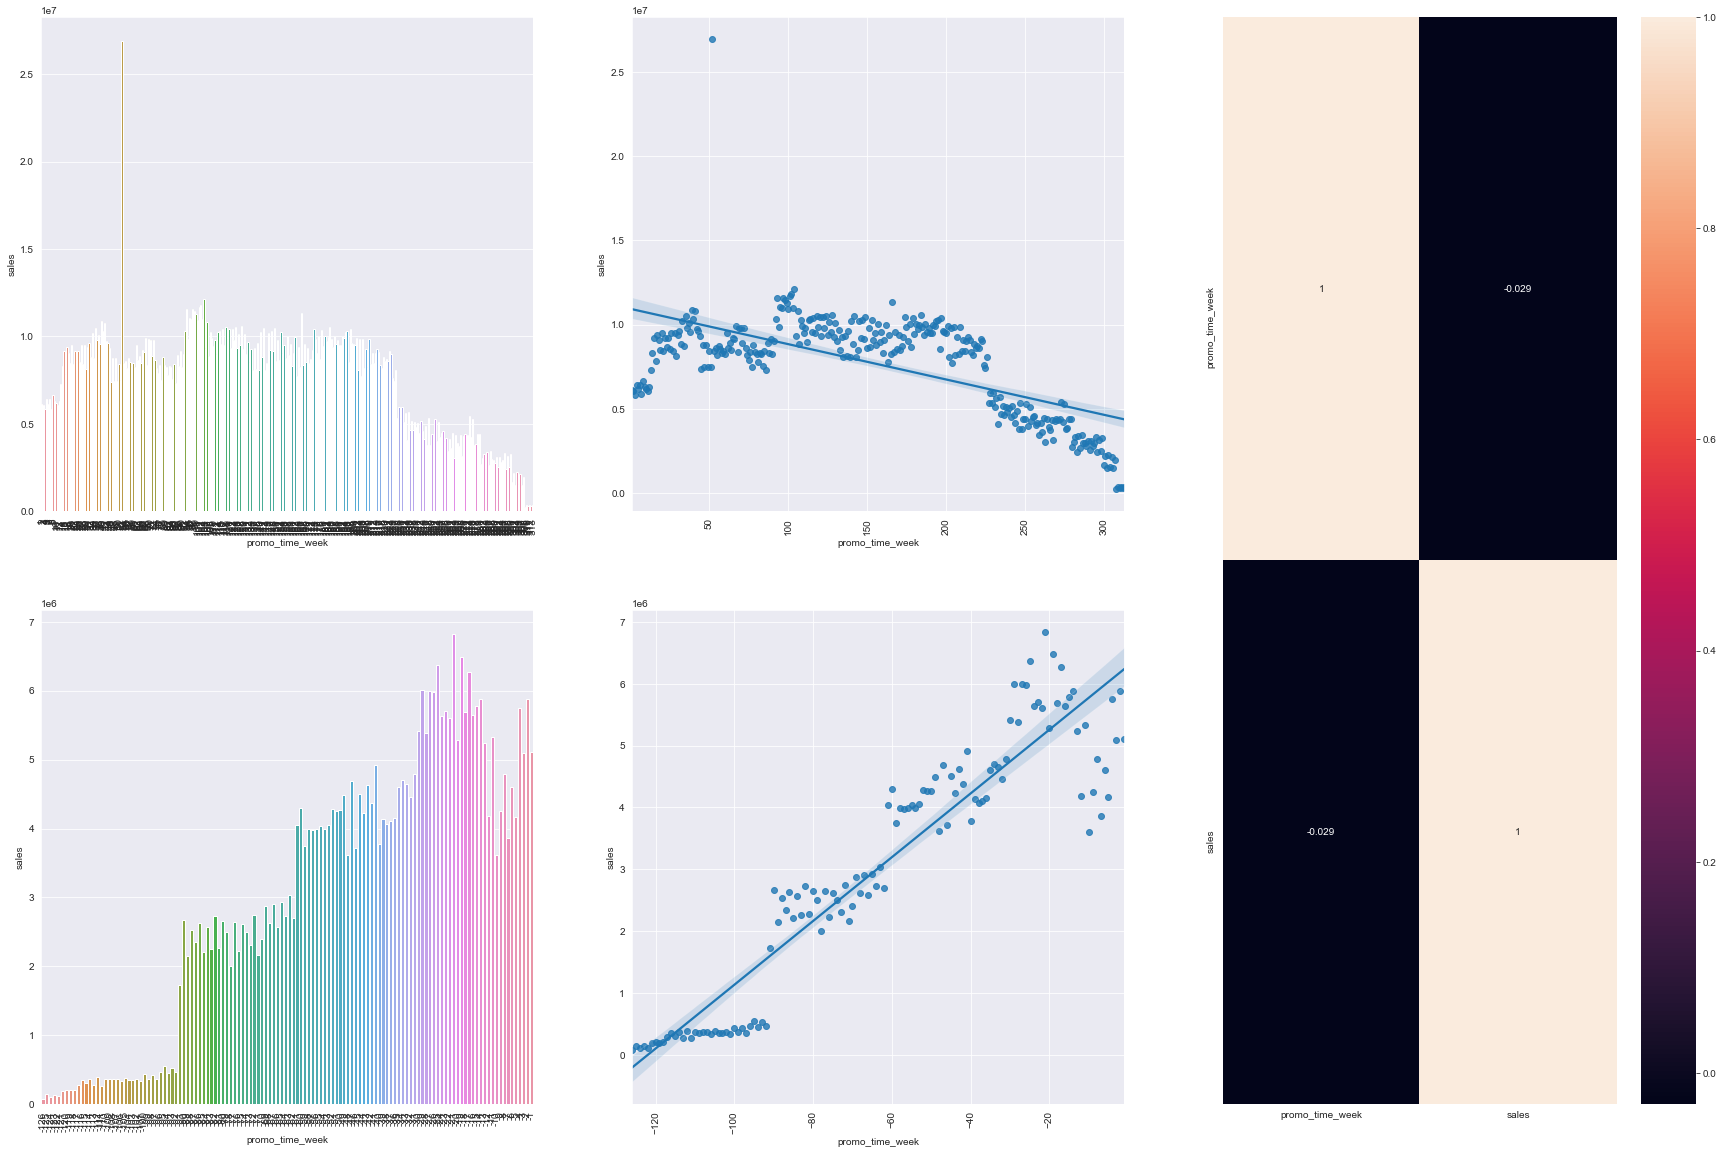

In [26]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
#sns.barplot(x='promo_time_week',y='sales',data=aux1);

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week']>0] # promo extend period
sns.barplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2);
plt.xticks(rotation=90);


plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']<0] # promo regular period
sns.barplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)

In [27]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extend,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### <s> H5 - Stores with more days in promotion should have higher sales. </s>

### H6 - Stores with more consecutives promotions should have higher sales.
**FALSE**

In [28]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


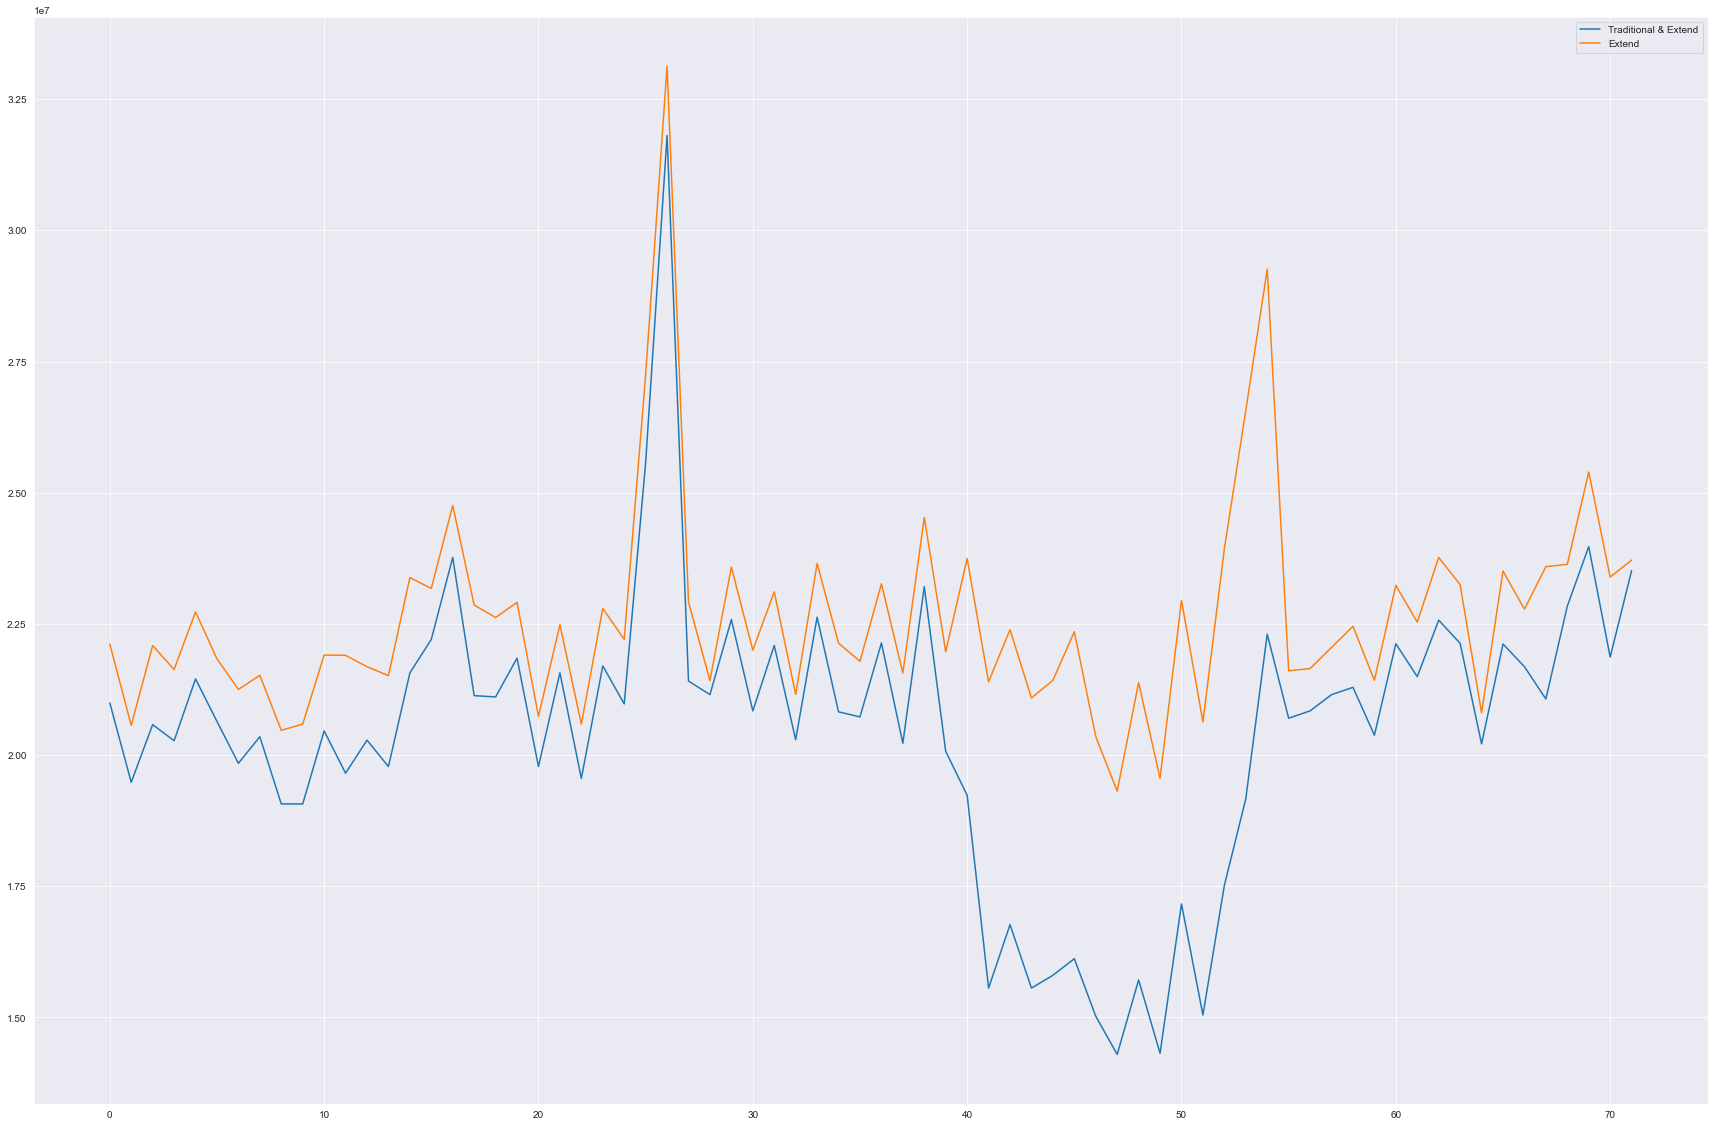

In [29]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Traditional & Extend','Extend'])

### H7 - Stores open during Christmas period should have higher sales.
***FALSE***

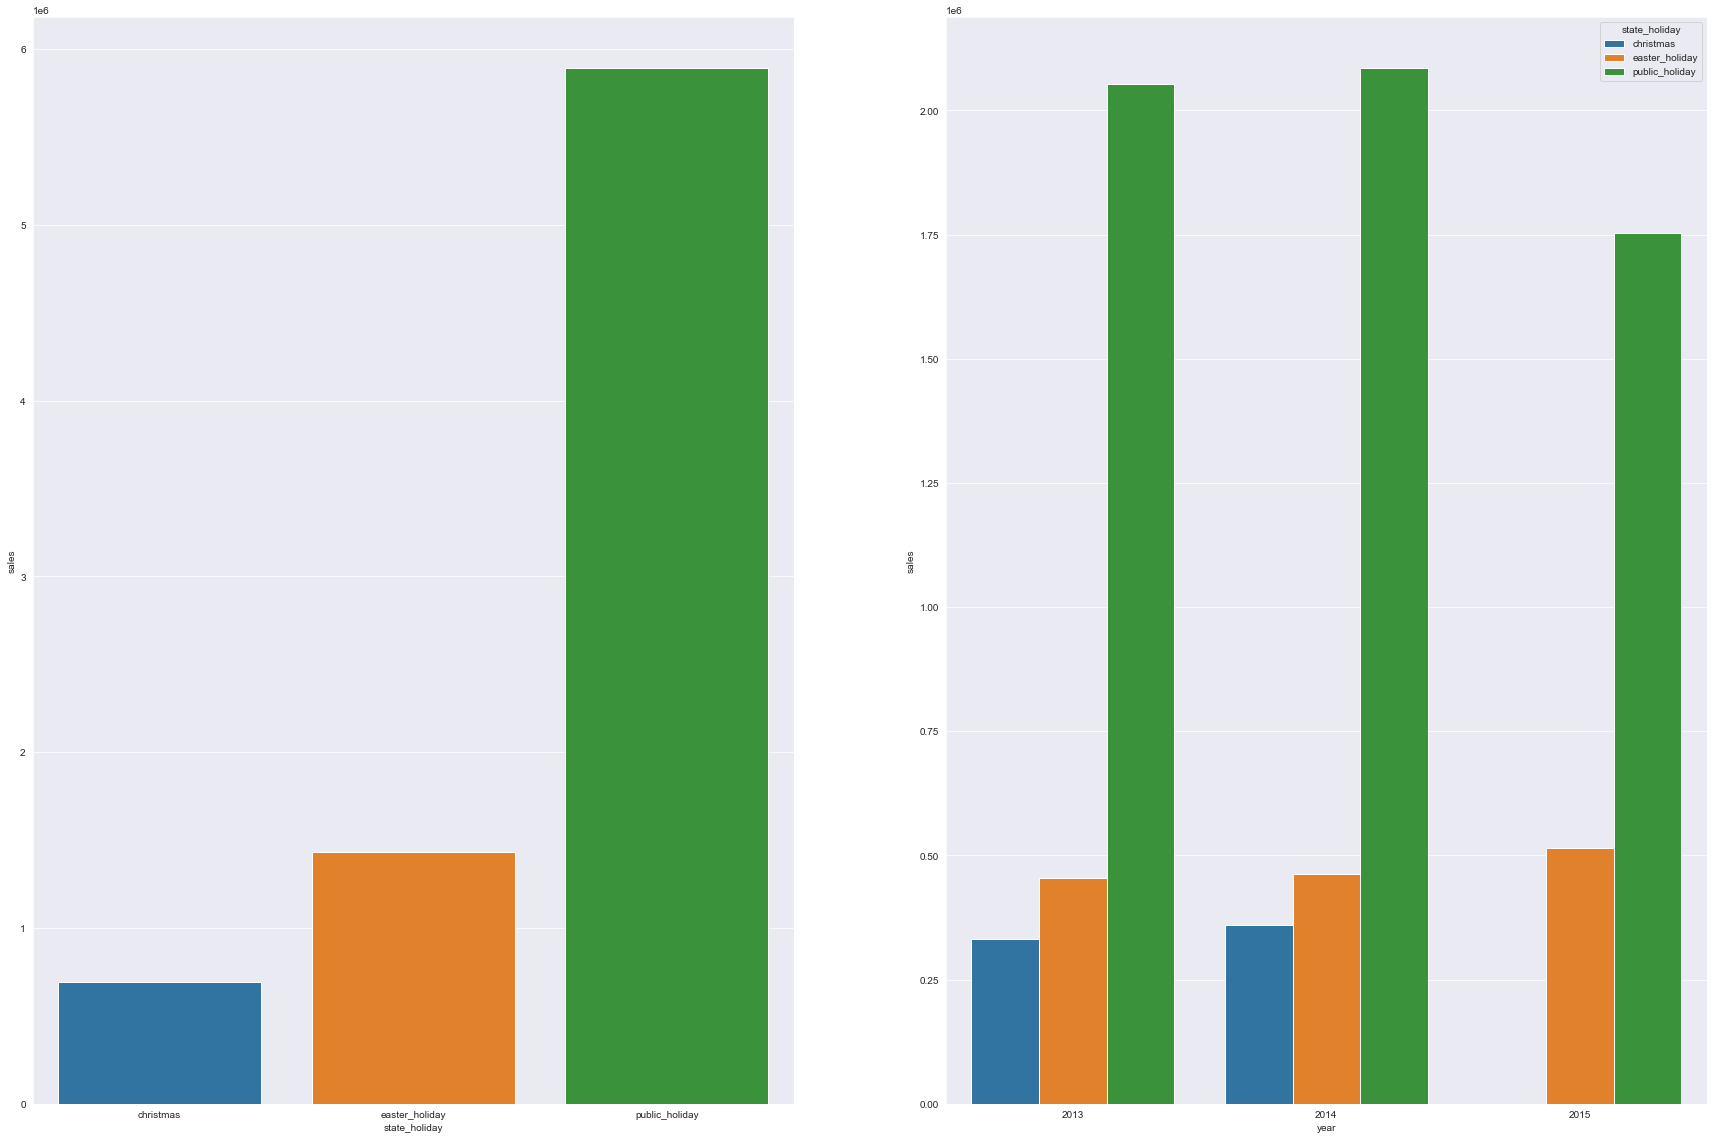

In [30]:
aux = df4[df4['state_holiday']!='regular_day']
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux2);

### H8 - Stores should increase their sales year by year
***FALSE***

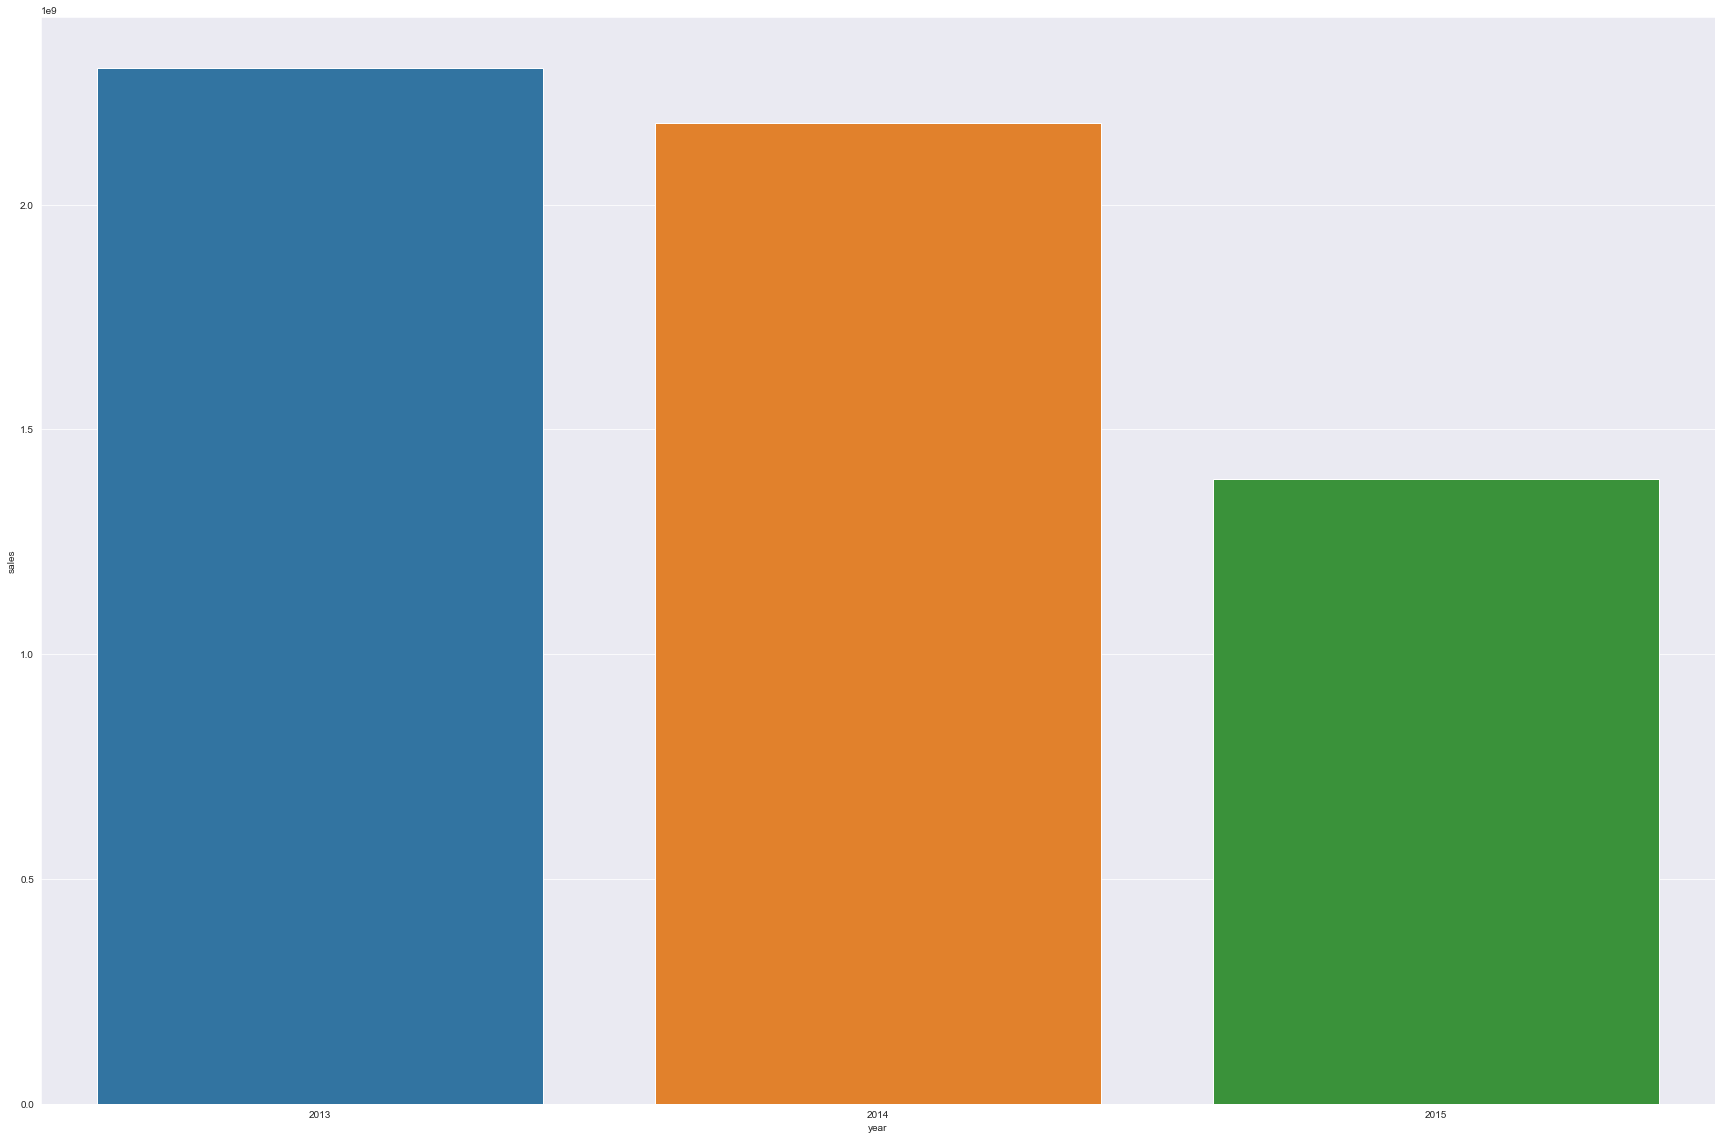

In [31]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

### H10 - Stores should have higher sales after the 10th of each month
**FALSE** (Stores sell more in the first 10 days of the month if we compare the same period within the month)

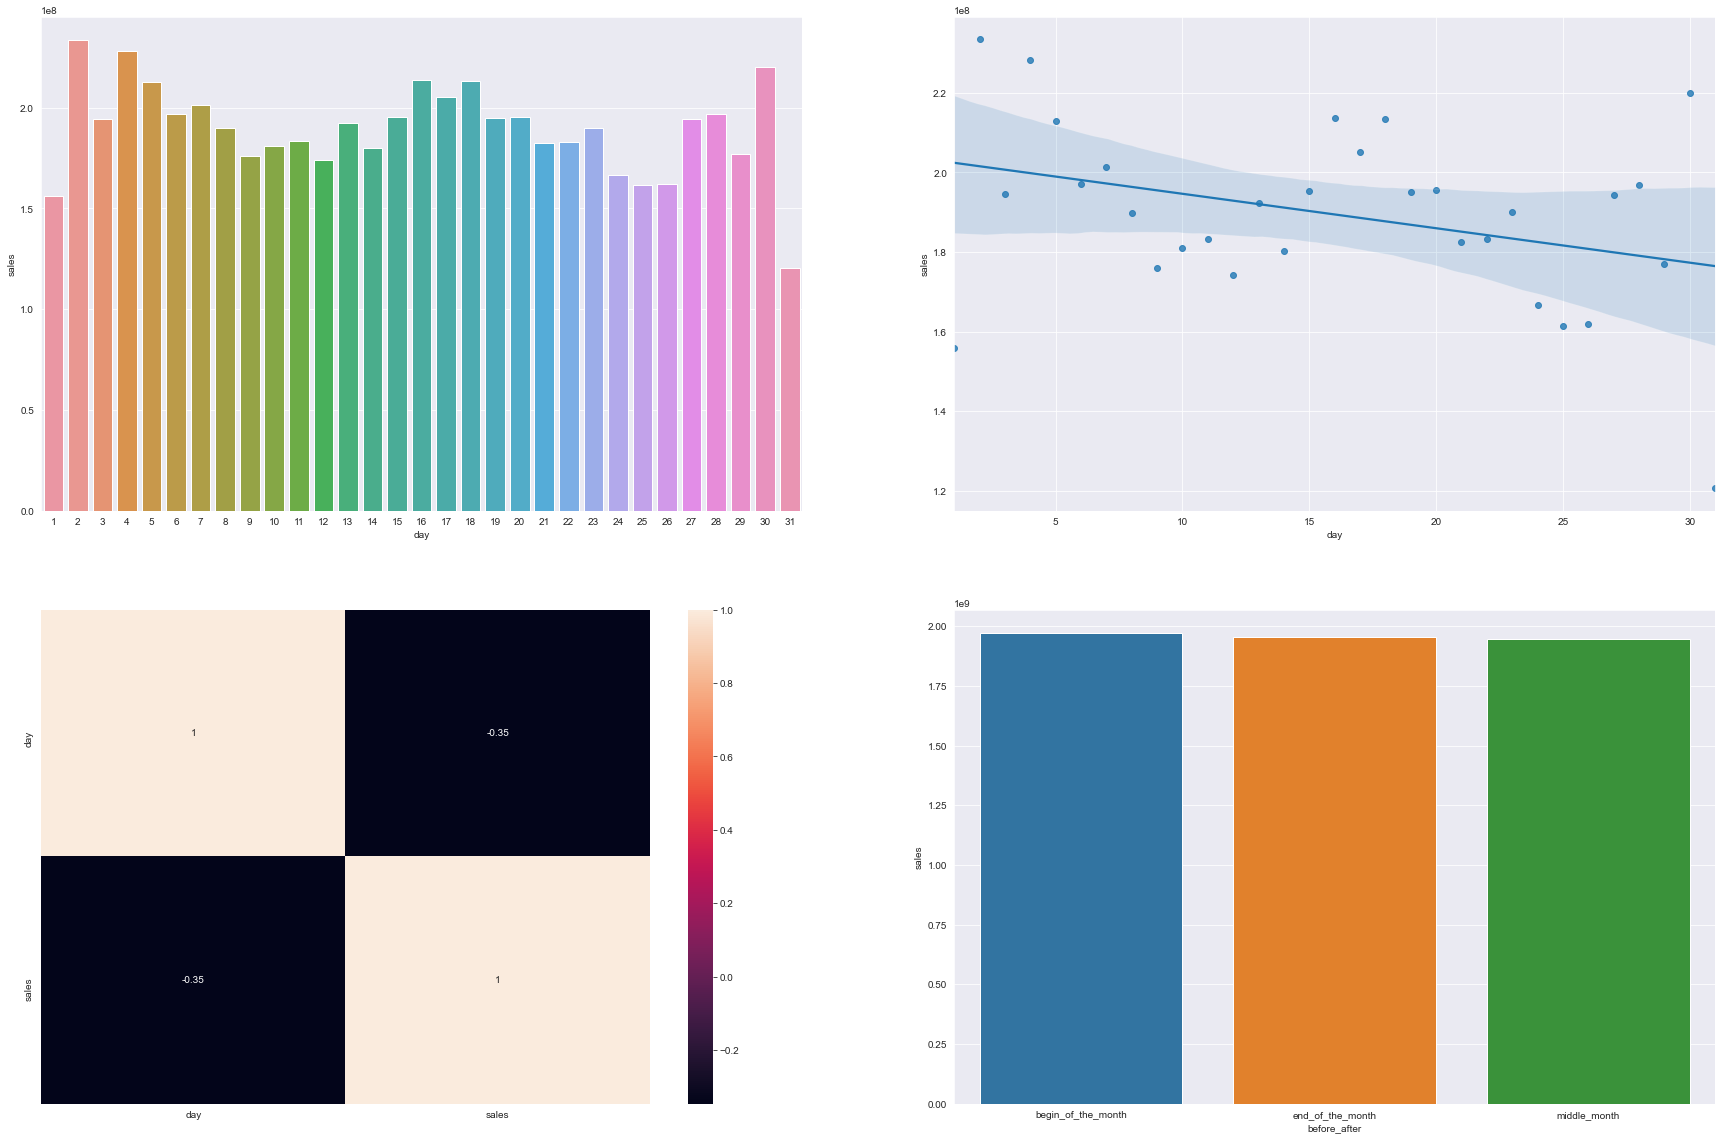

In [32]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

aux1['before_after'] = aux1['day'].apply(lambda x: 'begin_of_the_month' if x<=10 else 'middle_month' if (x>=11) & (x<=20) else 'end_of_the_month')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after',y='sales',data=aux2);


### H11 - Stores should have lower sales on weekends
***TRUE***

<AxesSubplot:>

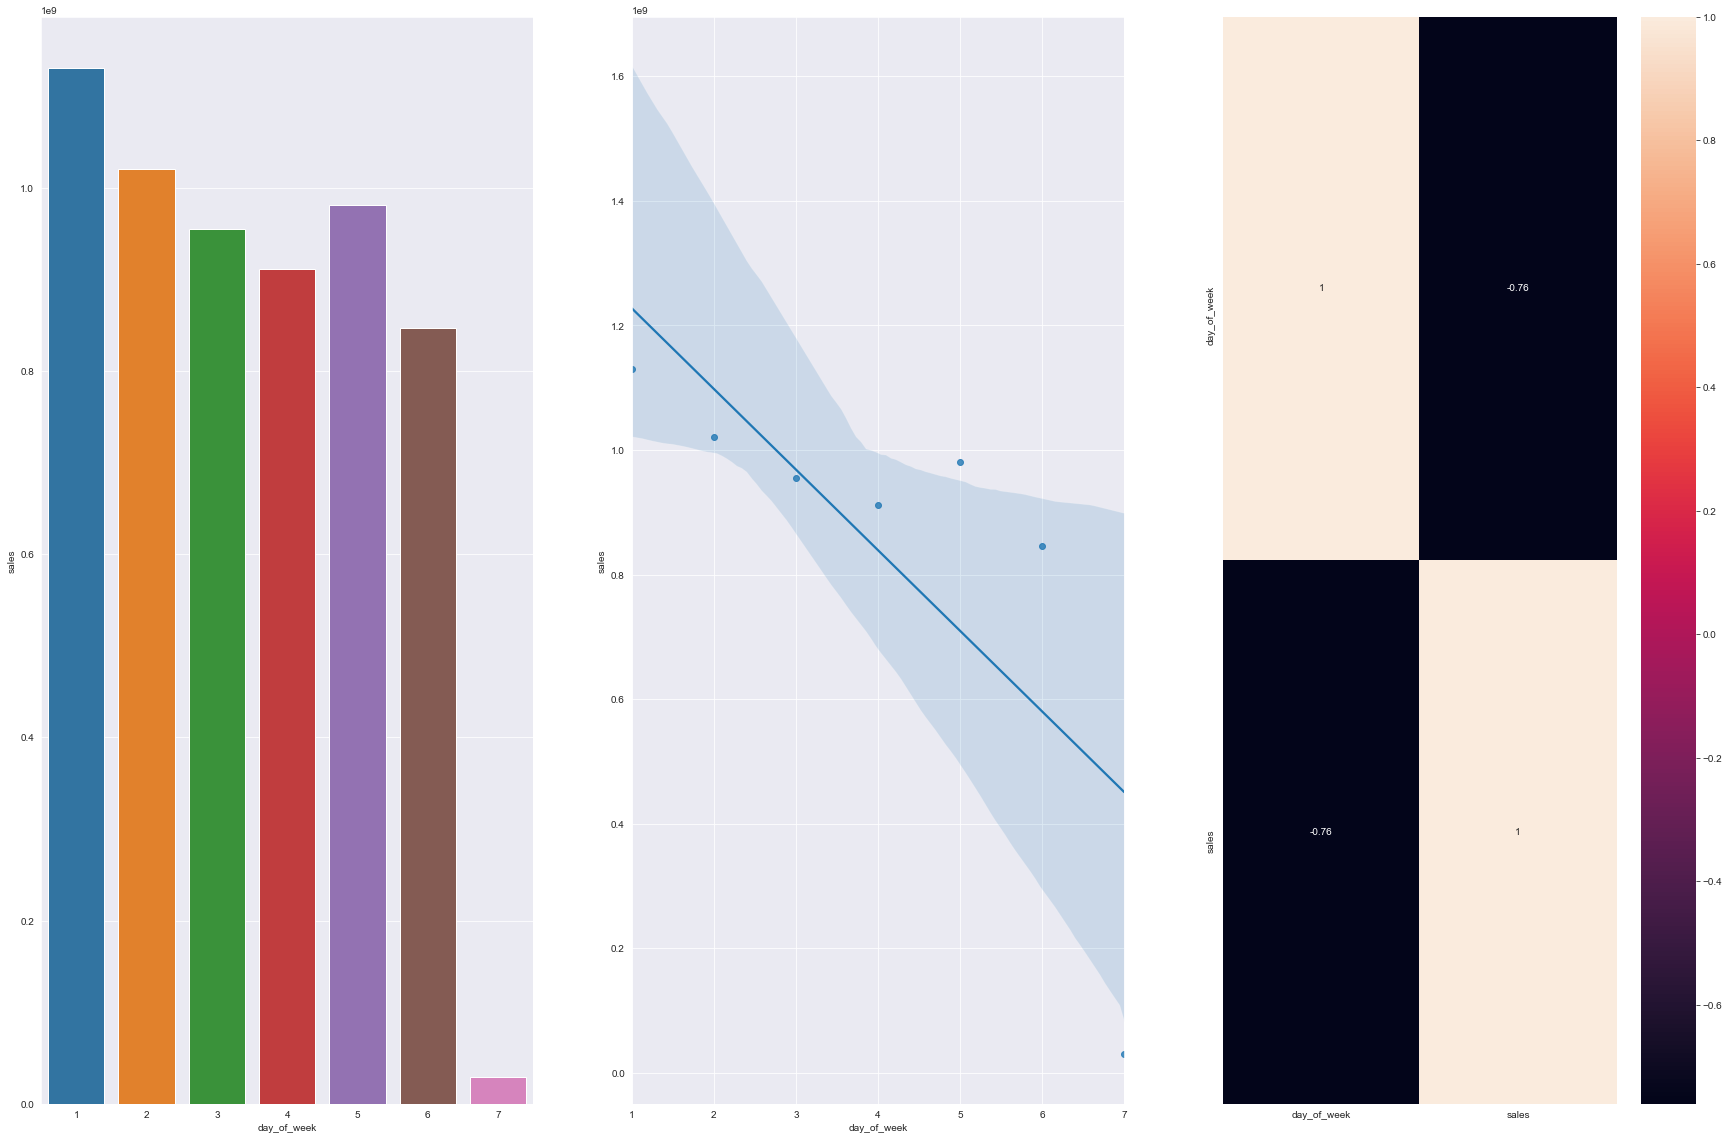

In [33]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True)

### H12 - Stores should have lower sales on school holidays
***TRUE*** (Except July and August)

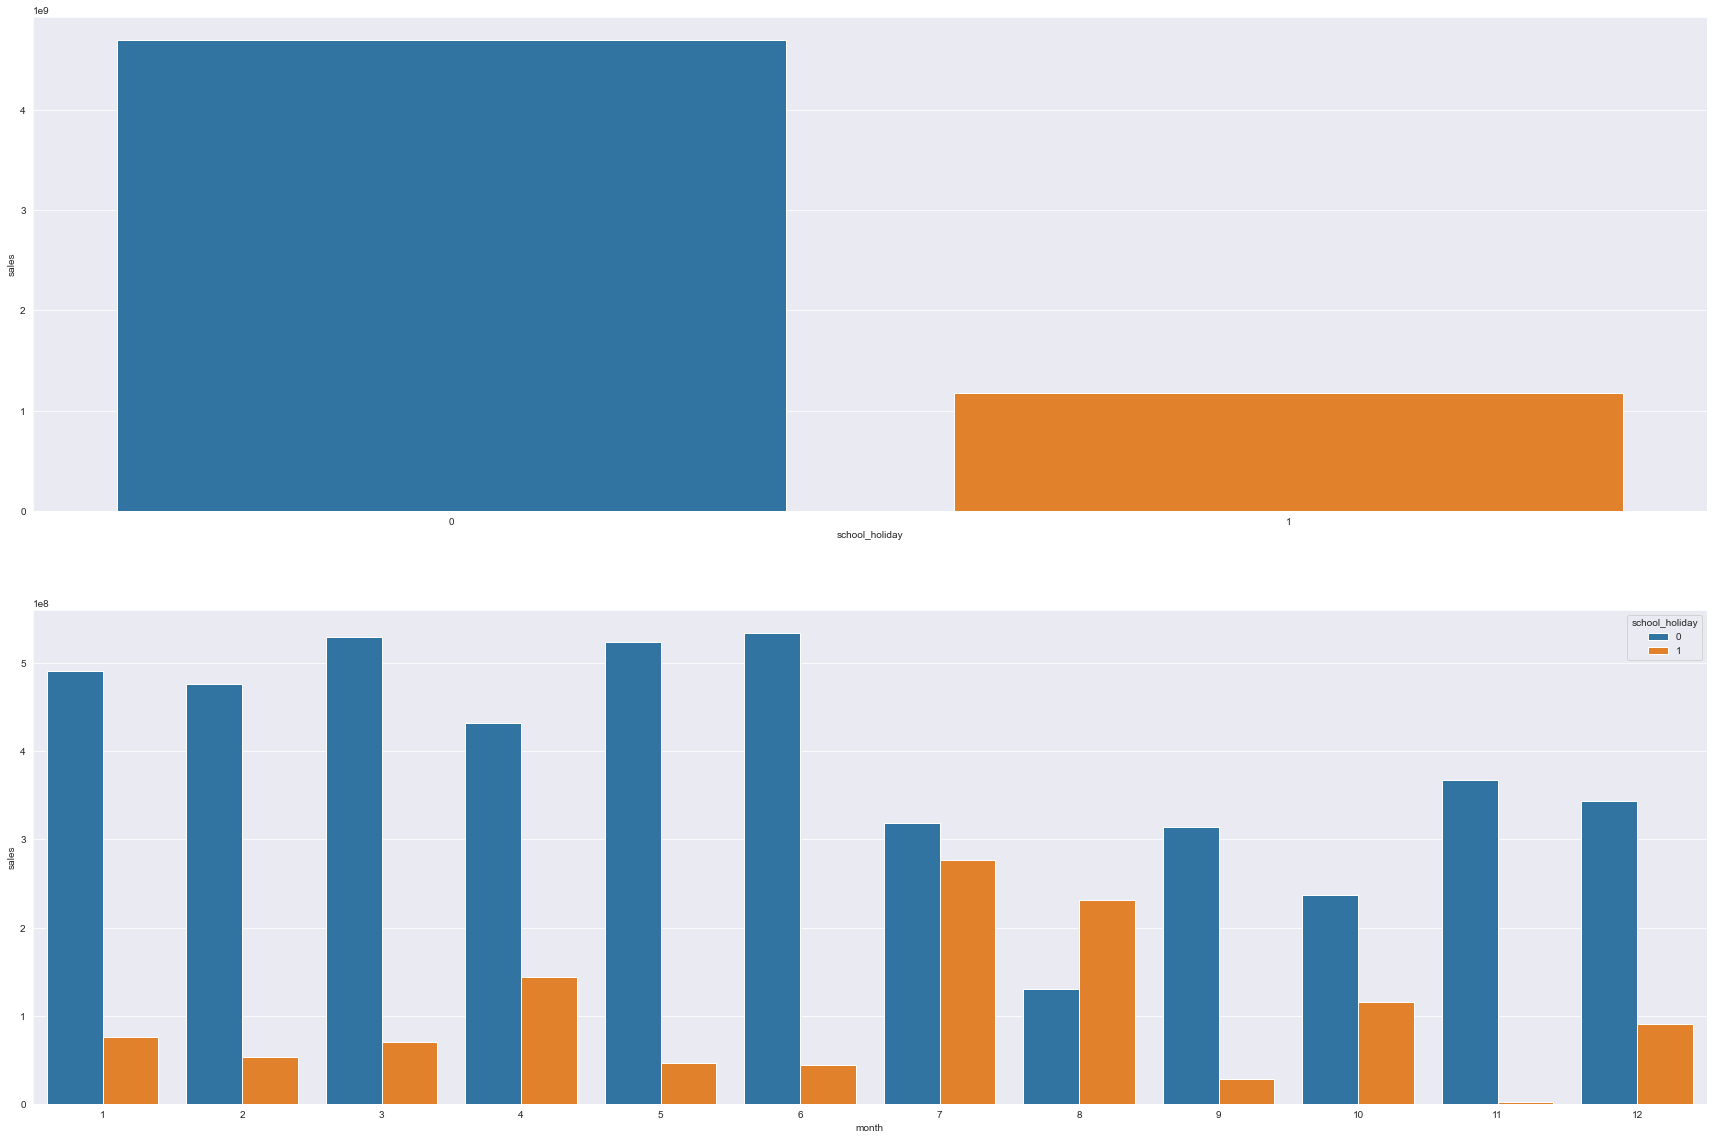

In [34]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x='school_holiday',y='sales',data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux2);

## Multivariate Analysis

### Numerical Attributes

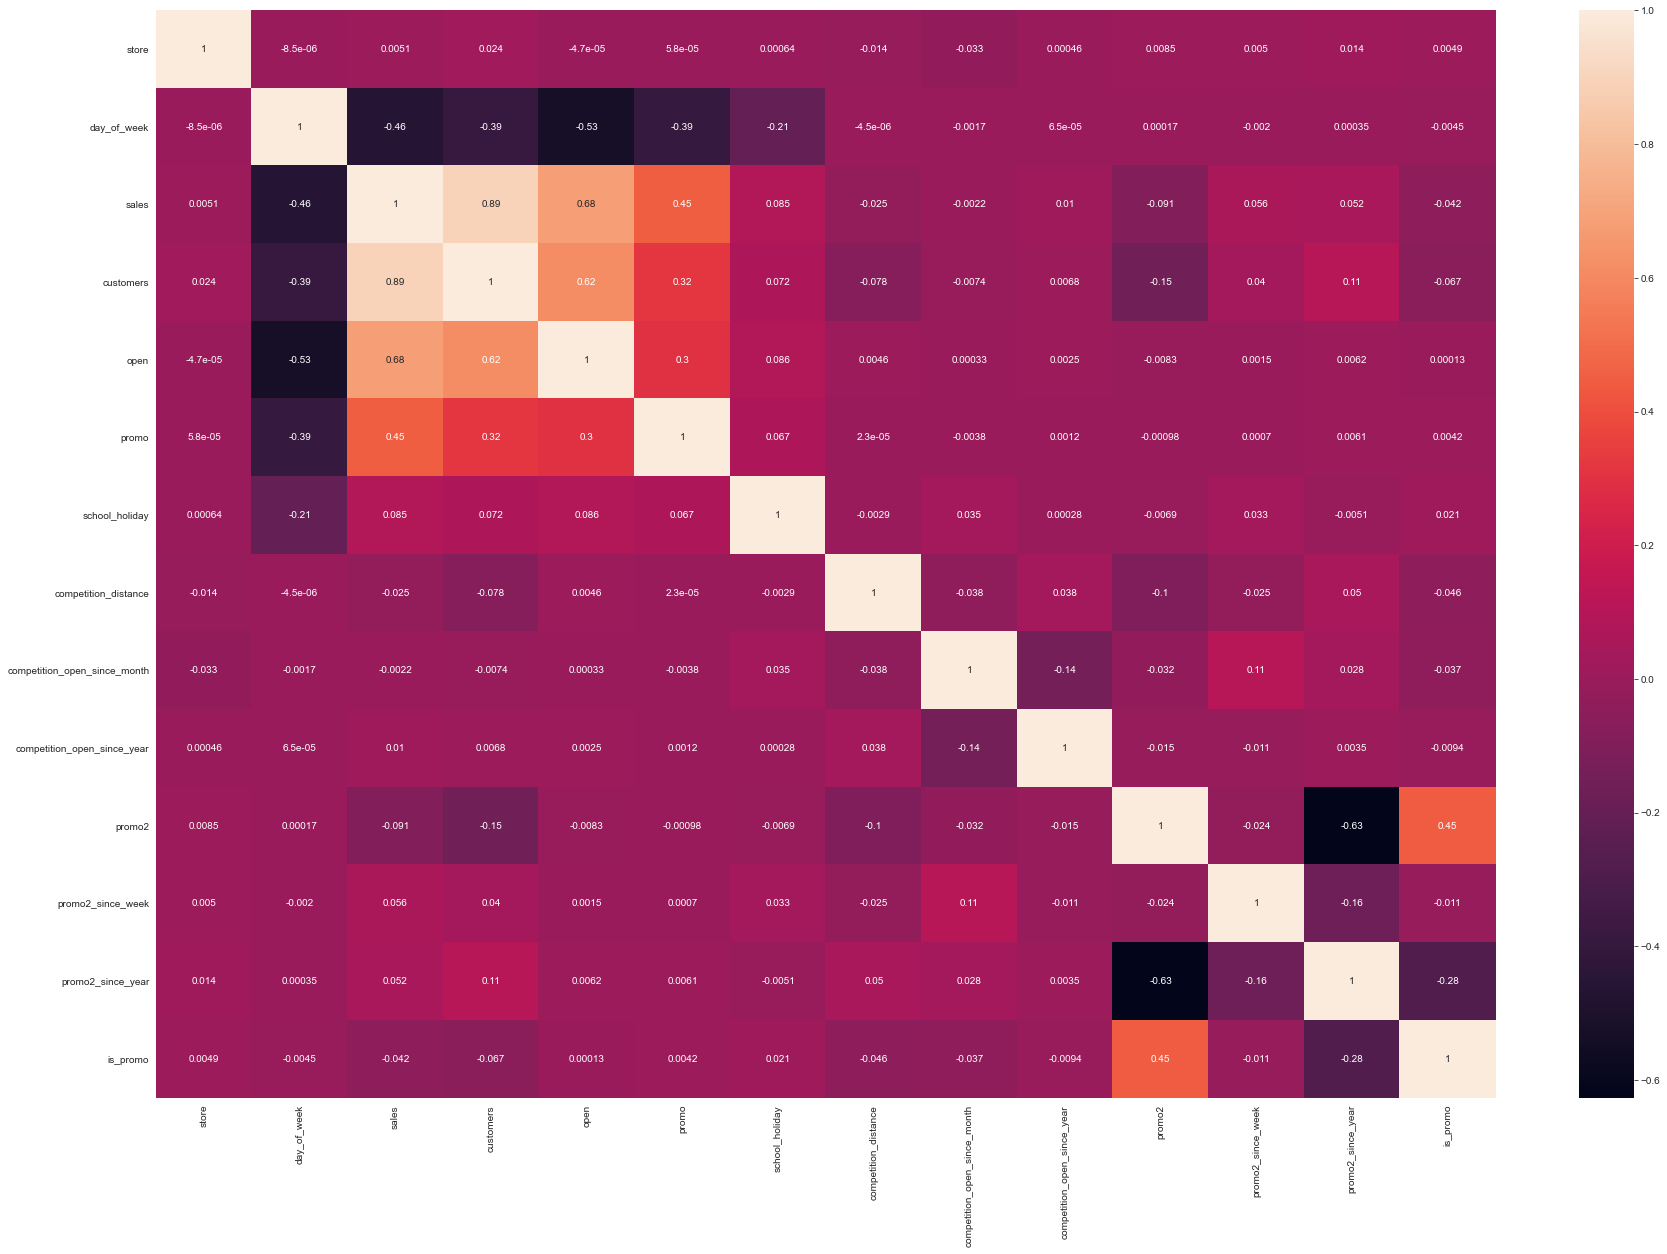

In [35]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation,annot=True);

### Categorical Attributes

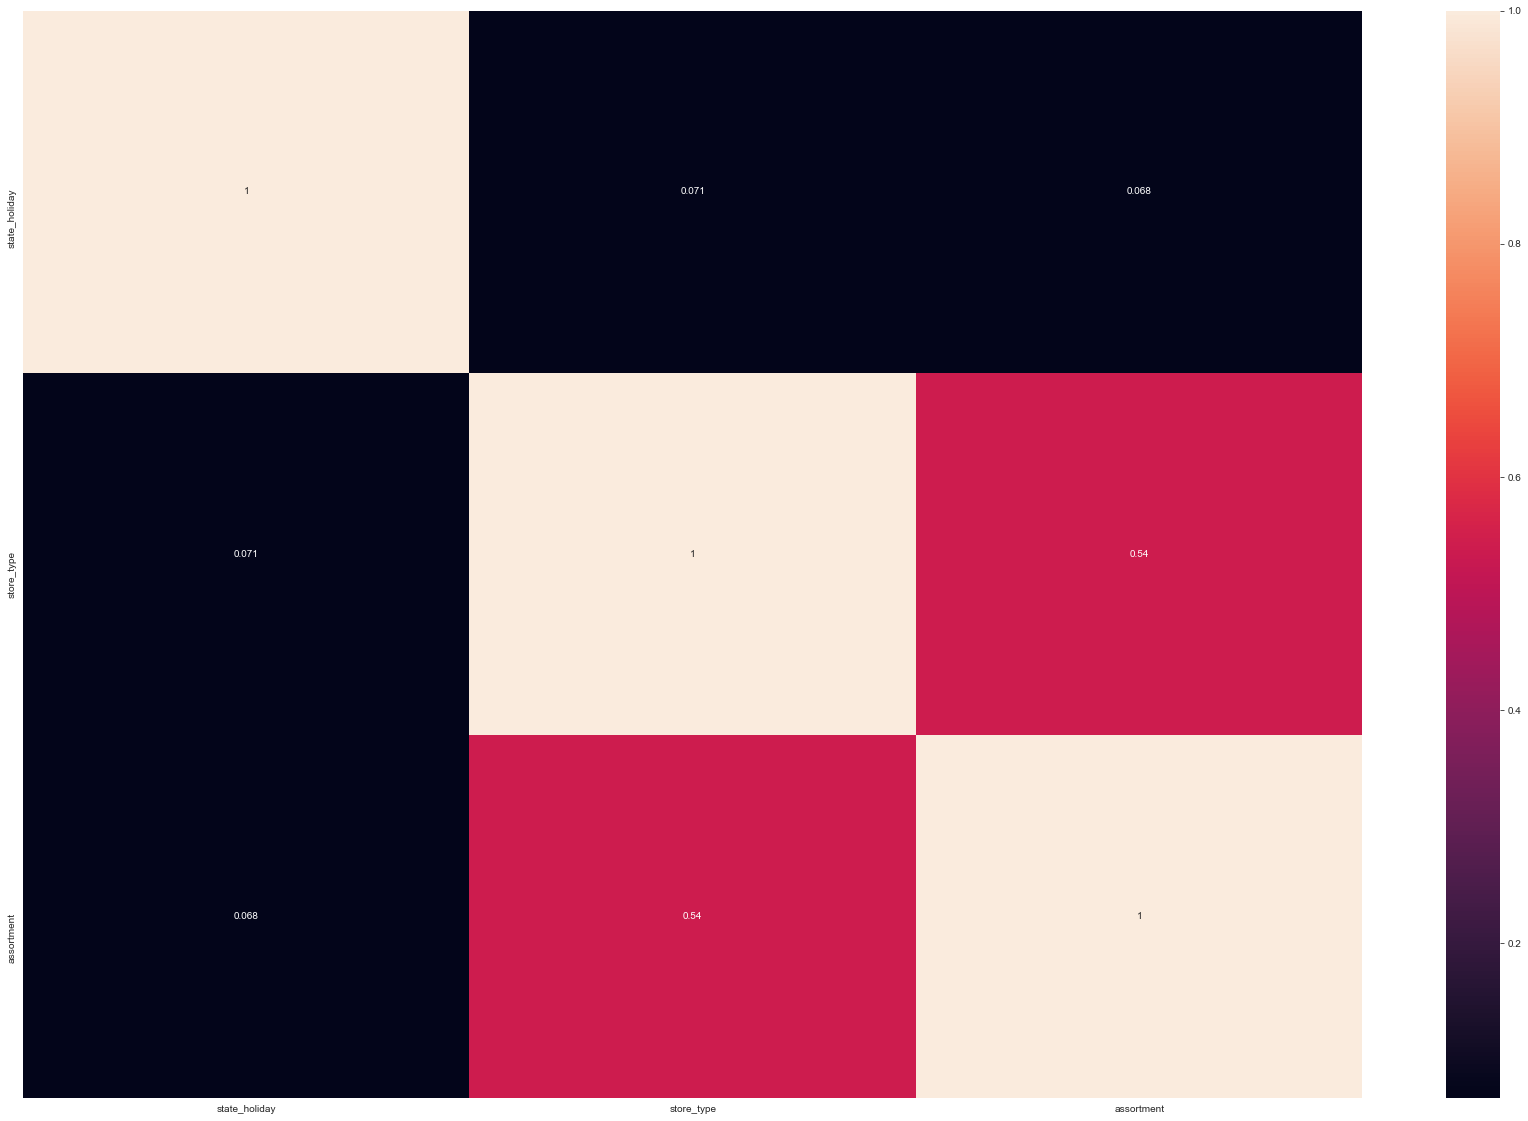

In [36]:
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday':[a1,a2,a3], 'store_type':[a4,a5,a6], 'assortment':[a7,a8,a9]})
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# Data Preparation

In [37]:
df5 = df4.copy()

## Normalization

## Rescaling

In [38]:
rs = RobustScaler()
mms = MinMaxScaler()
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs,open('parameter/competition_distance_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms,open('parameter/year_scaler.pkl','wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs,open('parameter/competition_time_month_scaler.pkl','wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms,open('parameter/competition_time_week_scaler.pkl','wb'))

## Transformation

## Encoding

In [39]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le,open('parameter/store_type_scaler.pkl','wb'))

# assortment - Ordinal Encoding
assortment_dict = {'basic':1,'extra':2,'extend':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

## Response Variable Transformation

In [40]:
df5['sales'] = np.log1p(df5['sales'])

## Nature Transformation

In [41]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# Feature Selection

In [42]:
df6 = df5.copy()

## Split df into training and test dataset

In [43]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop,axis=1)

In [44]:
df6[['store','date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [45]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0]-datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [46]:
# Training Dataset
x_train = df6[df6['date']<'2015-06-19']
y_train = x_train['sales']

# Test Dataset
x_test = df6[df6['date']>='2015-06-19']
y_test = x_test['sales']

print('Training Min Date: {}'.format(x_train['date'].min()))
print('Training Max Date: {}'.format(x_train['date'].max()))

print('\nTest Min Date: {}'.format(x_test['date'].min()))
print('Test Max Date: {}'.format(x_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## Boruta as feature selector

In [47]:
# Training and test DataSet for Boruta
#x_train_n = x_train.drop(['date','sales'],axis=1).values
#y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# Define Boruta
#boruta = BorutaPy(rf,n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

In [48]:
#cols_selected = boruta.support_.tolist()

# Best Features
#x_train_fs = x_train.drop(['date','sales'],axis=1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.to_list()

# Not Selected
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

## Manual Feature Selection 

In [49]:
## Manual outcome from Boruta Analysis
cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
cols_not_selected_boruta = ['is_promo','month_sin','school_holiday','state_holiday_christmas','state_holiday_easter_holiday','state_holiday_public_holiday','state_holiday_regular_day','week_of_year_sin','year']

feat_to_add = ['date','sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# Machine Learning Modelling 

In [50]:
x_train2 = x_train[cols_selected_boruta]
x_test2 = x_test[cols_selected_boruta]

x_training = x_train[cols_selected_boruta_full]

## Average Model

In [51]:
aux1=x_test2.copy()
aux1['sales']=y_test.copy()

#Prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2,how='left',on='store')
yhat_baseline = aux1['predictions']

#Performance
baseline_result = ml_error('Average Model',np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression Model

In [52]:
#Model
lr = LinearRegression().fit(x_train2,y_train)

#Prediction
yhat_lr = lr.predict(x_test2)

#Perfomance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


In [53]:
#Cross Validation
lr_result_cv = cross_validation(x_training,5,'Linear Regression',lr)
lr_result_cv

,Model Name,MAE Cross Validation,MAPE Cross Validation,RMSE Cross Validation
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## Linear Regression Regularized Model - Lasso

In [54]:
#Model
#lrr = Lasso(alpha=0.01).fit(x_train2,y_train)

#Prediction
#yhat_lrr = lrr.predict(x_test2)

#Perfomance
#lrr_result = ml_error('Linear Regression - Lasso',np.expm1(y_test),np.expm1(yhat_lrr))
#lrr_result

In [55]:
#Cross Validation
#lrr_result_cv = cross_validation(x_training,5,'Linear Regression - Lasso',lrr)
#lrr_result_cv

## Random Forest Regressor

In [56]:
#Model
#rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train2,y_train)

#Prediction
#yhat_rf = rf.predict(x_test2)

#Perfomance
#rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat_rf))
#rf_result

In [57]:
#Cross Validation
#rf_result_cv = cross_validation(x_training,5,'Random Forest Regressor',rf)
#rf_result_cv

## XGBoost Regressor

In [58]:
#Model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=100,eta=0.01,max_depth=10,subsample=0.7).fit(x_train2,y_train)

#Prediction
#yhat_xgb = model_xgb.predict(x_test2)

#Perfomance
#xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb))
#xgb_result

In [59]:
#Cross Validation
#xgb_result_cv = cross_validation(x_training,5,'XGBoost Regressor',model_xgb)
#xgb_result_cv

## Comparing Model's Performance

In [60]:
#modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
#modelling_result.sort_values('RMSE')

#modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv,xgb_result_cv])
#modelling_result_cv

# Hyper Parameter Fine Tuning

## Random Search

In [61]:
# param = {'n_estimators':[1500,1700,2500,3000,3500],'eta':[0.01,0.03],'max_depth':[3,5,9],'subsample':[0.1,0.5,0.7],'colsample_bytree':[0.3,0.7,0.9],'min_child_weight':[3,8,15]}
# MAX_EVAL = 5

In [62]:
# final_result = pd.DataFrame()
# for i in range(MAX_EVAL):
#     #random choose
#     hp = {k: random.sample(v,1)[0] for k, v in param.items()}
#     print(hp)
#     #Model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=hp['n_estimators'],eta=hp['eta'],max_depth=hp['max_depth'],subsample=hp['subsample'],colsample_bytree=hp['colsample_bytree'],min_child_weight=hp['min_child_weight'])
    
#     #Perfomance
#     result = cross_validation(x_training,5,'XGBoost Regressor',model_xgb)
#     final_result = pd.concat([final_result,result])

# final_result

## Final Model

In [63]:
# param_tuned = {'n_estimators':3000,'eta':0.03,'max_depth':5,'subsample':0.7,'colsample_bytree':0.7,'min_child_weight':3}

# #Model
# model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=param_tuned['n_estimators'],eta=param_tuned['eta'],max_depth=param_tuned['max_depth'],subsample=param_tuned['subsample'],colsample_bytree=param_tuned['colsample_bytree'],min_child_weight=param_tuned['min_child_weight']).fit(x_train2,y_train)

# #Prediction
# yhat_xgb_tuned = model_xgb_tuned.predict(x_test2)

# #Perfomance
# xgb_result_tuned = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_xgb_tuned))
# xgb_result_tuned

In [64]:
# pickle.dump(model_xgb_tuned,open('/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/pickled_model/model_xgb_tuned.pkl','wb'))
# pickle.dump(yhat_xgb_tuned,open('/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/pickled_model/yhat_xgb_tuned.pkl','wb'))
# pickle.dump(xgb_result_tuned,open('/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/pickled_model/model_tuned.pkl','wb'))

with open('pickled_model/model_tuned.pkl', 'rb') as f:
    xgb_result_tuned = pickle.load(f)
with open('pickled_model/yhat_xgb_tuned.pkl', 'rb') as g:
    yhat_xgb_tuned = pickle.load(g)

# Error Analysis

In [65]:
df9=x_test[cols_selected_boruta_full]

#rescale
df9['sales']=np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

<ipython-input-65-8dc800391226>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales']=np.expm1(df9['sales'])
<ipython-input-65-8dc800391226>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1(yhat_xgb_tuned)


## Business Performance

In [66]:
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})
df9_aux3 = pd.merge(df9_aux1,df9_aux2,how='inner',on='store')
df92 = pd.merge(df91,df9_aux3,how='inner',on='store')
 
df92['worst_scenario'] = df92['predictions']-df92['MAE']
df92['best_scenario'] = df92['predictions']+df92['MAE']

df92 = df92[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

In [67]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108633.421875,105215.855006,112050.988744,3417.566869,0.611000
908,909,224070.859375,216207.836065,231933.882685,7863.023310,0.519385
901,902,201215.421875,199774.680704,202656.163046,1440.741171,0.360233
169,170,204235.546875,202820.591902,205650.501848,1414.954973,0.349286
875,876,193354.765625,189231.731169,197477.800081,4123.034456,0.332036


<AxesSubplot:xlabel='store', ylabel='MAPE'>

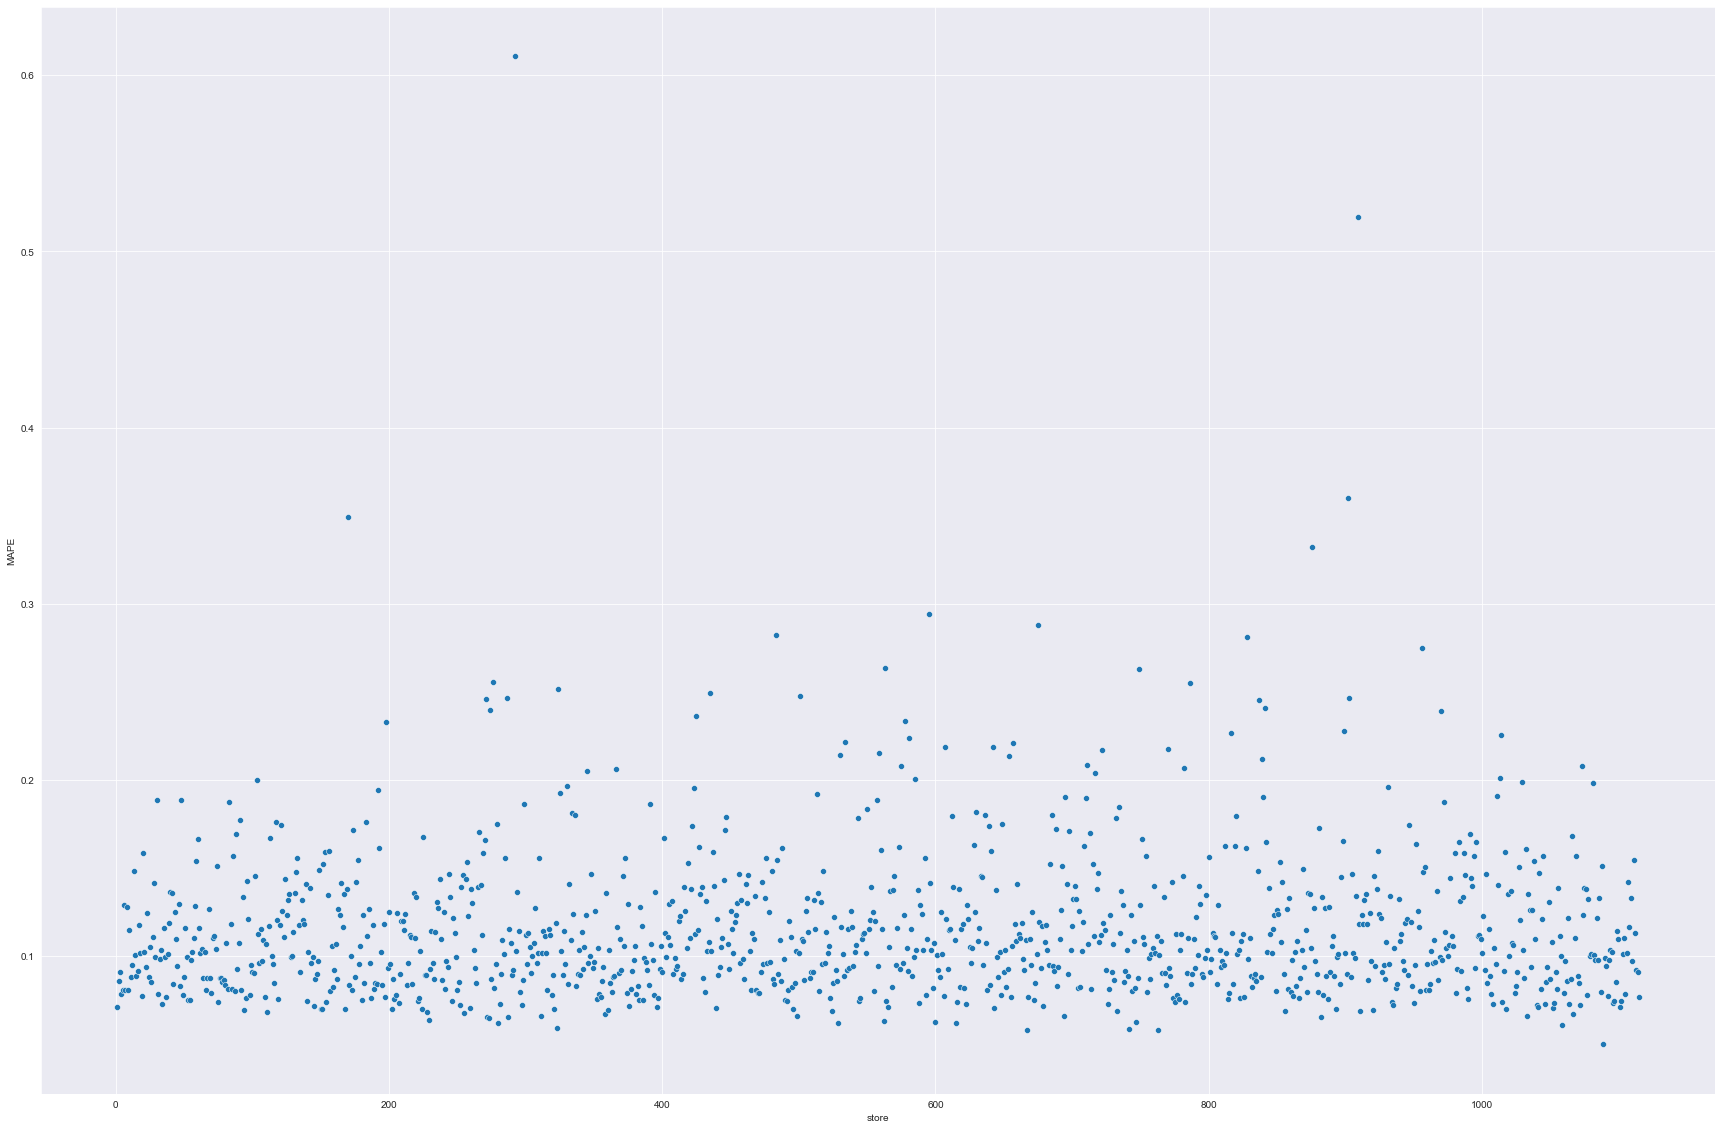

In [68]:
sns.scatterplot(x='store',y='MAPE',data=df92)

## Total Performance

In [69]:
df93 = df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x),axis=0).reset_index().rename(columns={'index':'Scenarios',0:'Values'})
df93['Values'] = df93['Values'].map('$ {:,.2f}'.format)
df93


,Scenarios,Values
0,predictions,"$ 286,559,328.00"
1,worst_scenario,"$ 285,703,455.06"
2,best_scenario,"$ 287,415,190.64"


## Machine Learning Performance

In [70]:
df9['error'] = df9['sales']-df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

<ipython-input-70-00283d60be79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales']-df9['predictions']
<ipython-input-70-00283d60be79>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions']/df9['sales']


/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/dwerneck/.pyenv/versions/dsproducao/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

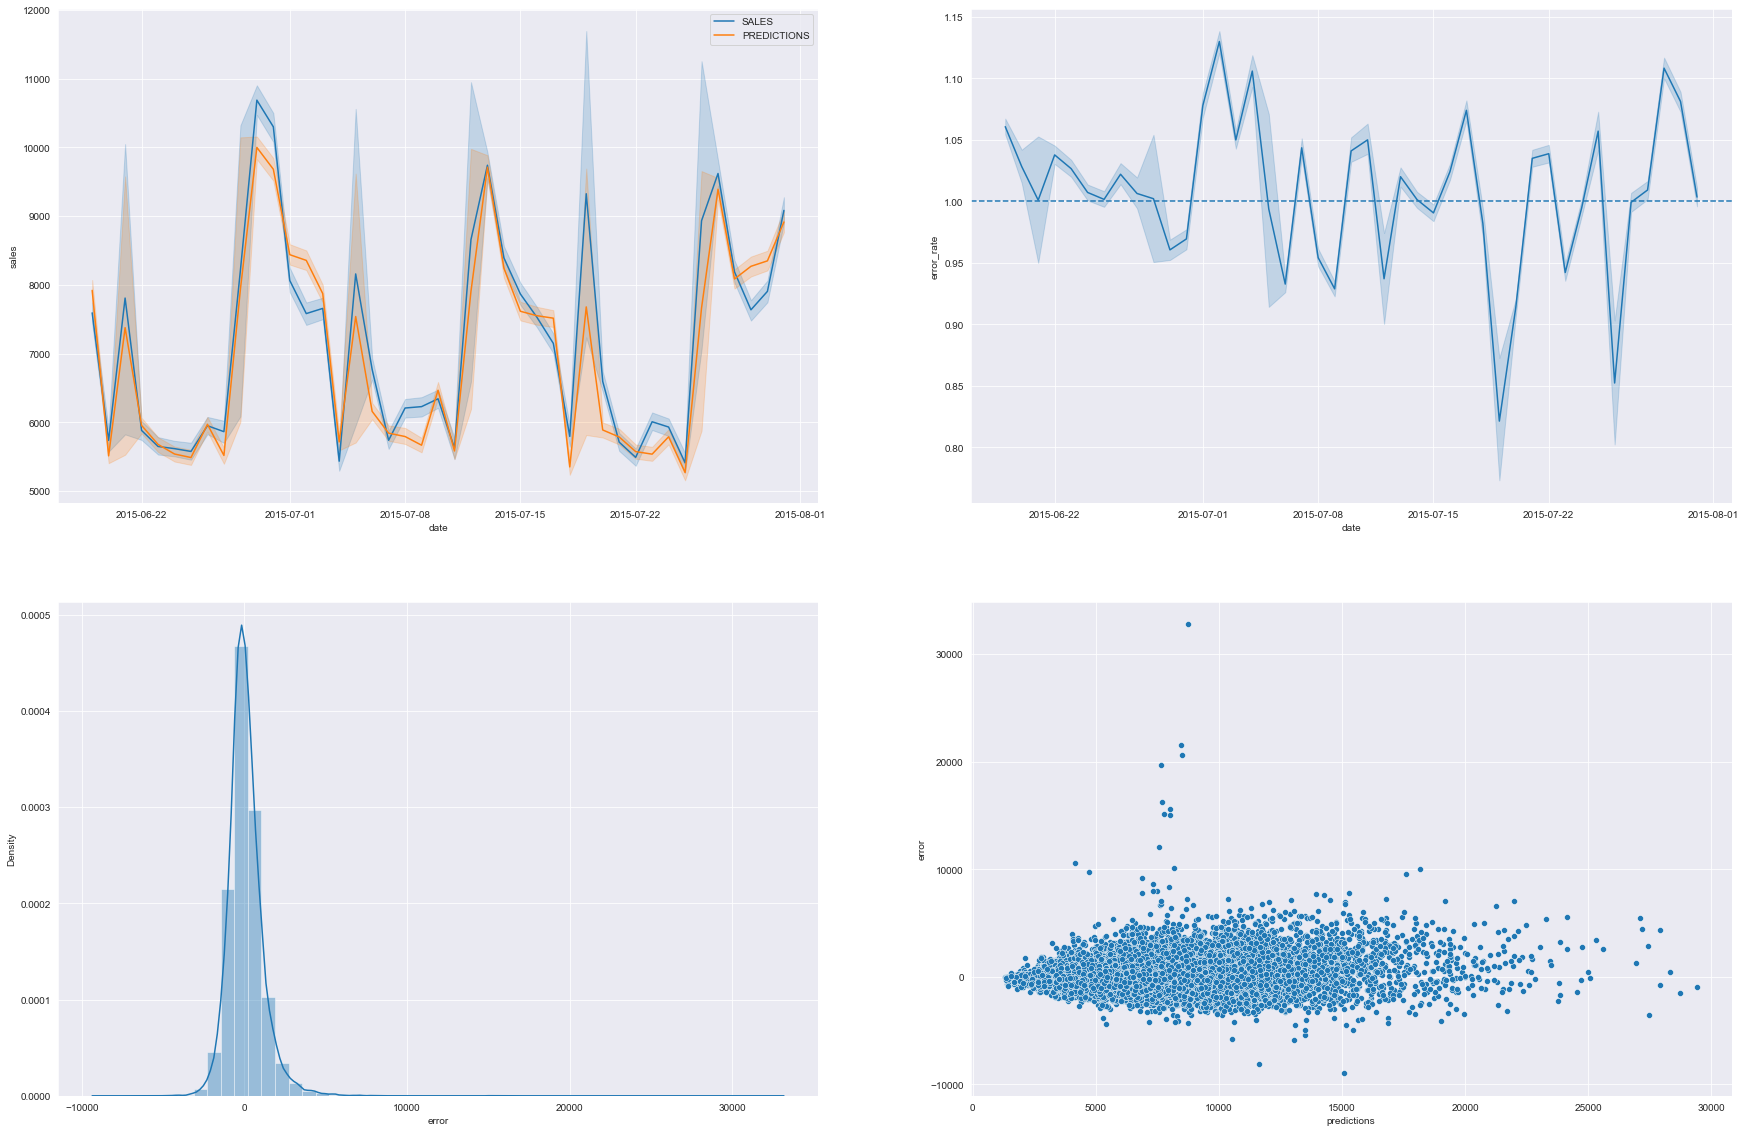

In [71]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df9,label='SALES')
sns.lineplot(x='date',y='predictions',data=df9,label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df9)
plt.axhline(1,linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'],df9['error'])


# Deploy Model to Production 

## Rossmann Class 

In [72]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/competition_time_week_scaler.pkl','rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl','rb'))
    
    def data_cleaning(self,df):
        
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,cols_old))
        df.columns = cols_new
        
        ## Data types
        df['date'] = pd.to_datetime(df['date'])


        ## Filling NA

        df['competition_distance'] = df['competition_distance'].fillna(200000)
        df['competition_open_since_month'] = df.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        df['competition_open_since_year'] = df['competition_open_since_year'].fillna(df['date'].dt.year)
        df['promo2_since_week'] = df['promo2_since_week'].fillna(df['date'].dt.isocalendar().week)
        df['promo2_since_year'] = df['promo2_since_year'].fillna(df['date'].dt.year)
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec' }
        df['promo_interval'].fillna(0, inplace=True)
        df['month_map'] = df['date'].dt.month.map(month_map)
        df['is_promo'] = df[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## Change Types

        df['competition_open_since_month'] = df['competition_open_since_month'].astype(int)
        df['competition_open_since_year'] = df['competition_open_since_year'].astype(int)
        df['promo2_since_week'] = df['promo2_since_week'].astype(int)
        df['promo2_since_year'] = df['promo2_since_year'].astype(int)
        
        return df

    def feature_engineering(self,df2):
        
        # year
        df2['year']=df2['date'].dt.year
        # month
        df2['month']=df2['date'].dt.month
        # day
        df2['day']=df2['date'].dt.day
        # week of year
        df2['week_of_year']=df2['date'].dt.week
        # year week
        df2['year_week']=df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date']-df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

        # assortment

        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extend')

        # state holiday

        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x =='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        # Variables Filtering
        df2 = df2[df2['open']!=0]
        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2

    def data_preparation(self,df5):

        #rescaling
        ##competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)
        # year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)
        # competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)
        # promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)
        
        ## Encoding

        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies(df5,prefix=['state_holiday'],columns=['state_holiday'])

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        # assortment - Ordinal Encoding
        assortment_dict = {'basic':1,'extra':2,'extend':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ## Nature Transformation

        # day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2*np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2*np.pi/30)))

        # week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2*np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year','promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos','month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        
        return df5[cols_selected]
    
    def get_prediction(self,model,original_data,test_data):
        # Prediction
        pred = model.predict(test_data)
        # Join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')
    

## API Handler 

In [73]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# Loading Model
model = pickle.load(open('/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/pickled_model/model_rossmann.pkl','rb'))

app = Flask(__name__)

@app.route('/rossmann/predict',methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json,dict):
            test_raw = pd.DataFrame(test_json,index=[0])
        else:
            test_raw = pd.DataFrame(test_json,columns=test_json[0].keys())
            
        # Instantiate Rossmann Class
        pipeline = Rossmann()
        # Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        # Data Preparation
        df3 = pipeline.data_preparation(df2)
        # Prediction
        df_response = pipeline.get_prediction(model,test_raw,df3)
        
        return df_response
        
    else:
        return Response('{}',status=200,mimetype='application/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## API Tester

In [ ]:
df10 = pd.read_csv('/Users/dwerneck/Desktop/data_science/Meigarom/ds_producao/data_raw/test.csv')

In [ ]:
df_test = pd.merge(df10,df_store_raw,how='left',on='Store')

# Choosing store for prediction
df_test = df_test[df_test['Store'].isin([21,22])]

# Remove Closed days and Id
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id',axis=1)

# Convert df to json
data = json.dumps(df_test.to_dict(orient='records'))

In [ ]:
# API call
url = 'https://dwck-rossmann-model.herokuapp.com/rossmann/predict'
#url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'http://192.168.1.145:5000/rossmann/predict'
header = {'Content-type':'application/json'}
data = data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format(r.status_code))

In [ ]:
d11 = pd.DataFrame(r.json(),columns=r.json()[0].keys())

In [ ]:
d22 = d11[['store','prediction']].groupby('store').sum().reset_index()

In [ ]:
for i in range(len(d22)):
    print('The sales forecast to the store number #{} is ${:,.2f} in the next 6 weeks.'.format(d22.loc[i,'store'],d22.loc[i,'prediction']))